# Prepare data

In [1]:
from os.path import join
from pathlib import Path

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import random
import seaborn as sns

from pytorch_lightning.metrics.functional import accuracy, confusion_matrix
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from threadpoolctl import threadpool_info, threadpool_limits 
from torch import nn
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchaudio import transforms
from torchvision.transforms import RandomApply, Compose

from audio_loader.features.raw_audio import WindowedAudio
from audio_loader.features.mfcc import WindowedMFCC
from audio_loader.ground_truth.timit import TimitGroundTruth
from audio_loader.samplers.dynamic_sampler import DynamicSamplerFromGt
from audio_loader.dl_frontends.pytorch.fill_ram import pad_collate_supervised_contrastive, pad_collate_supervised_contrastive_valid_test

/home/vroger/.miniconda3/envs/audio_loader/lib/python3.8/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


In [2]:
for lib in threadpool_info(): 
    threadpool_limits(limits=max(2, int(lib['num_threads']/6)), user_api=lib['user_api'])

# Dataloader lightning

In [3]:
def aug_func(p=0.):
    return Compose([
        RandomApply([transforms.TimeMasking(2)], p=p),
        RandomApply([transforms.FrequencyMasking(1)], p=p)
    ])


class TrainSiameseDataset(Dataset):
    """ """

    def __init__(self, data, number_of_classes, augmentations=None):
        """ data must be  """
        self.data = data
        self.dict_class_data = {}
        self.number_of_classes = number_of_classes
        self.augmentations = augmentations
        
        # initialize dict
        for i in range(self.number_of_classes):
            self.dict_class_data[i] = []

        # fill the dict
        for datum in self.data:
            self.dict_class_data[datum[1]].append(datum[0])

    def __len__(self):
        """ """
        return len(self.data)

    def __getitem__(self, index):
        """ """
        similarity = random.randint(0, 1)
        datum = self.data[index]
        if similarity == 0:
            # positif sample
            datum_to_compare = random.choice(self.dict_class_data[datum[1]])
        else:
            # negatif sample
            other_classes = list(range(self.number_of_classes))
            other_classes.remove(datum[1])
            other_class = random.choice(other_classes)
            datum_to_compare = random.choice(self.dict_class_data[other_class])

        if self.augmentations is not None:
            return datum[0], datum_to_compare, similarity
        else:
            return self.augmentations(datum[0].clone()), self.augmentations(datum_to_compare.clone()), similarity


class ValidTestSiameseDataset(Dataset):
    """ """

    def __init__(self, data):
        """ 
        Args:
            data: list of tuples (data, gt)
            anchor_data: list of tuples (data, gt) being the anchors
        """
        self.data = data

    def __len__(self):
        """Return the size of the set times the number of anchors used."""
        return len(self.data)

    def __getitem__(self, index):
        """Return a tuple of (data, anchor ) corresponding to the index."""
        datum = self.data[index]
        return datum[0], datum[1]

In [4]:
class TimitMFCCDataModule(pl.LightningDataModule):

    def __init__(self, data_dir, batch_size, shots=5, batch_size_test=256):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.batch_size_test = batch_size_test
        self.shots = shots
    
    def prepare_data(self):
        self.timit_gt = TimitGroundTruth(self.data_dir, with_silences=False, phon_class="phon_class2", return_original_gt=True)
        self.timit_gt.set_gt_format(phonetic=True, word=False, speaker_id=True)
        self.mfcc_feature_processor = WindowedMFCC(400, 160, 16000, 13, delta_orders=[1, 2], delta_width=9)
        self.sampler = DynamicSamplerFromGt([self.mfcc_feature_processor], self.timit_gt)
        
    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            data_train = [(torch.tensor(x[0]),
                           y[:-1].argmax(),
                           y_label,
                           y[-1],
                           self.timit_gt.index2speaker_id[int(y[-1])][0],
                           self.timit_gt.df_all[self.timit_gt.df_all['speaker_id'] == self.timit_gt.index2speaker_id[int(y[-1])]]["dialect_region"].values[0])
                          for x, (y, y_label) in self.sampler.get_samples_from("train", randomize_files=False)]
            # select the anchors, the rest will be used for valid data
            self.df_data_train = pd.DataFrame(data_train, columns=['datum', 'gt', 'original_label', 'speaker_id', "sex", 'region']) 
            all_speaker_id = self.df_data_train['speaker_id'].unique()
            all_unique_gt = self.df_data_train['gt'].unique()
            
            dict_type_per_class = {}
            for gt in all_unique_gt:
                dict_type_per_class[gt] = self.df_data_train[self.df_data_train['gt'] == gt]['original_label'].unique()
                
            all_original_labels = self.df_data_train['original_label'].unique()
            speaker_used_overall = [[] for i in range(self.number_of_classes)]
            

            self.anchor_data, self.valid_data, speaker_used_overall = self.select_samples(data_train,
                                                                                  self.shots,
                                                                                  speaker_used=speaker_used_overall,
                                                                                  region_constraint=False,
                                                                                 dict_type_per_class=dict_type_per_class)
            
            self.train_dataset = TrainSiameseDataset(self.anchor_data, self.number_of_classes, aug_func())
            
            # take less few samples for the valid set to avoid too long computation time
            i_classes = np.zeros(self.number_of_classes)
            examples_per_class_valid = 20
    
            self.valid_data, self.nu_data, speaker_used_overall = self.select_samples(self.valid_data,
                                                                              examples_per_class_valid,
                                                                              speaker_used=speaker_used_overall,
                                                                              region_constraint=False,
                                                                             dict_type_per_class=dict_type_per_class)
            
            self.valid_dataset = ValidTestSiameseDataset(self.valid_data)
            return
        
        if stage == 'test' or stage is None:
            data_test = [(torch.tensor(x[0]),
                               y[:-1].argmax(),
                               y[-1],
                               self.timit_gt.index2speaker_id[int(y[-1])][0],
                               self.timit_gt.df_all[self.timit_gt.df_all['speaker_id'] == self.timit_gt.index2speaker_id[int(y[-1])]]["dialect_region"].values[0])
                              for x, (y, y_label) in self.sampler.get_samples_from("test")]
            self.df_data_test = pd.DataFrame(data_test, columns=['datum', 'gt', 'speaker_id', "sex", 'region']) 
            self.test_dataset = ValidTestSiameseDataset(data_test)
            return

    
    def select_samples(self, data, shots, speaker_used, region_constraint=False, dict_type_per_class=None):
        """Return a tuple with anchors, unused data and the speaker id used per class."""
        
        anchor_data = []
        # initialise counters
        number_of_sample_selected = np.zeros(self.number_of_classes)
        male_per_phon = np.zeros(self.number_of_classes)
        female_per_phon = np.zeros(self.number_of_classes)
        limit_female = round(shots / 2.)
        limit_male = shots - limit_female
        
        dict_limit_per_type = {}
        dict_type_count = {}
        for label in dict_type_per_class:
            limit = math.ceil(shots/len(dict_type_per_class[label]))
            for original_label in dict_type_per_class[label]:
                dict_limit_per_type[original_label] = limit
                dict_type_count[original_label] = 0
        

        # region_used = [[] for i in range(self.number_of_classes)]
        region_used = np.zeros((self.number_of_classes, 8)) # 8 number of regions 
        region_goal = np.zeros((self.number_of_classes, 8)) # 8 number of regions
        for i in range(shots):
            region_goal[:, i%8] += 1

        if region_constraint:
            # fix as there is no example from R8 in some classes
            # don't work for shots > 10
            if self.number_of_classes == 58:
                region_goal[29, 7] = 0
                region_goal[50, 7] = 0
                region_goal[51, 7] = 0
                region_goal[29, 2] += 1
                region_goal[50, 2] += 1
                region_goal[51, 2] += 1

                if region_goal[50, 0] > 1: 
                    region_goal[50, 0] = 1
                    region_goal[51, 0] = 1
                    region_goal[50, 4] += 1
                    region_goal[51, 4] += 1

            elif self.number_of_classes == 47:
                # don't work for shots > 10
                region_goal[40, 7] -= 0
                region_goal[40, 0] -= 0
                region_goal[40, 2] += 1
                region_goal[40, 3] += 1
            elif self.number_of_classes == 39:
                # don't work for shots > 10
                region_goal[33, 7] -= 0
                region_goal[33, 0] -= 0
                region_goal[33, 2] += 1
                region_goal[33, 3] += 1

        i = 0
        number_anchors = 0
        expected_anchors = shots * self.number_of_classes
        # apply strategies to select data
        while i < len(data) and number_anchors < expected_anchors:
            datum, gt, original_gt, speaker_id, sex, region = data[i]
            if region_constraint:
                condition = number_of_sample_selected[gt] < shots and speaker_id not in speaker_used[gt] and region_used[gt, int(region[-1])-1] < region_goal[gt, int(region[-1])-1] and dict_type_count[original_gt] < dict_limit_per_type[original_gt]
            else:
                condition = number_of_sample_selected[gt] < shots and speaker_id not in speaker_used[gt] and dict_type_count[original_gt] < dict_limit_per_type[original_gt]
                
            if condition:
                if sex == "F":
                    if female_per_phon[gt] < limit_female:
                        female_per_phon[gt] += 1
                    else:
                        i += 1
                        continue
                else:
                    if female_per_phon[gt] < limit_male:
                        male_per_phon[gt] += 1
                    else:
                        i += 1
                        continue

                region_used[gt, int(region[-1])-1] += 1
                number_of_sample_selected[gt] += 1
                dict_type_count[original_gt] += 1
                speaker_used[gt].append(speaker_id)
                number_anchors += 1
                anchor_data.append((datum, gt))
                del data[i]
            else:
                i += 1

        if number_anchors < expected_anchors:
            print(region_goal-region_used)
            print(region_goal)
            print(region_used)
            print(f"number_of_sample_selected:\n{number_of_sample_selected}")
            print(f"speaker_used:\n{speaker_used}")
            raise Exception("strategy not possible")

        return anchor_data, data, speaker_used
    
    @property
    def number_of_classes(self):
        return self.sampler.number_of_classes-1  # minus one as the last dimension is for the speaker id
    
    @property
    def anchors(self):
        return self.anchor_data

    def train_dataloader(self):
        if len(self.train_dataset) < self.batch_size:
            raise Exception(f"Error the dataset size ({len(self.train_dataset)}) if inferior to the desired batch size ({self.batch_size})")
    
        data_loader =  DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True,
                                  collate_fn=pad_collate_supervised_contrastive,
                                  num_workers=1,
                                  drop_last=True)
        print(f"train {len(data_loader)}")
        return data_loader

    def val_dataloader(self):
        data_loader = DataLoader(self.valid_dataset, batch_size=self.batch_size_test, shuffle=False,
                                 collate_fn=pad_collate_supervised_contrastive_valid_test,
                                 num_workers=0,
                                 drop_last=False)
        print(f"valid {len(data_loader)}")
        return data_loader

    def test_dataloader(self):
        data_loader = DataLoader(self.test_dataset, self.batch_size_test , shuffle=False,
                                 collate_fn=pad_collate_supervised_contrastive_valid_test,
                                 num_workers=0,
                                 drop_last=False)
        print(f"test {len(data_loader)}")
        return data_loader

# Model definition

In [5]:
class lit_mfcc_model(pl.LightningModule):
    def __init__(self, feature_size, anchor_data, num_classes, num_shots, labels):
        """Init all parameters.
        
        feature_size: int
            size of the expected features for the forward step
        """
        super().__init__()
        self.feature_size = feature_size
        self.num_classes = num_classes
        self.num_shots = num_shots
        self.labels = labels
        
        # prepare the anchors for test and valid
        self.anchors_gt = [gt for data, gt in anchor_data]
        
        # prepare anchor data
        anchors = [data for data, gt in anchor_data]
        anchors_lens = [len(x) for x in anchors]
        anchors_padded = pad_sequence(anchors, batch_first=True, padding_value=0.)
        self.packed_anchors = pack_padded_sequence(anchors_padded, anchors_lens,
                                                   batch_first=True, enforce_sorted=False)

        # Initialize the model
        self.layer_1_grus = nn.GRU(
            feature_size, 256, 5,
            bidirectional=True,
            batch_first=True,
            dropout=0.2
        )
        
        self.bn_fwd = nn.BatchNorm1d(256)
        self.bn_bwd = nn.BatchNorm1d(256)
        self.layer_2_dense = torch.nn.Linear(512, 128)
        
        self.alpha = torch.nn.Linear(128, 128, bias=False)
        
        self.loss = torch.nn.BCEWithLogitsLoss(size_average=True)
        
    def forward_one(self, x):
        batch_size = x.batch_sizes[0]
        # shape: (num_layers*directions, batch_size, hidden_size?)
        h_0 = torch.zeros(5*2, batch_size, 256, device=self.device)
        output, h_n = self.layer_1_grus(x, h_0)

        fwd_h = h_n.view(5, 2, batch_size, 256)[-1, 0]
        bwd_h = h_n.view(5, 2, batch_size, 256)[-1, 1]
    
        fwd_h = self.bn_fwd(fwd_h.view(batch_size, 256))
        bwd_h = self.bn_bwd(bwd_h.view(batch_size, 256))

        h = torch.cat((fwd_h, bwd_h), 1)
        return self.layer_2_dense(h)
        

    def forward(self, xs):
        """Forward of the model over the data."""
        x1, x2 = xs
        emb1 = self.forward_one(x1)
        emb2 = self.forward_one(x2)
        
        siamese_dist = torch.sum(self.alpha(torch.abs(emb1 - emb2)), dim=1)
        return torch.reshape(siamese_dist, (emb1.shape[0], 1))
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0006) # initial fixed:  lr=0.0004)
        return {
            'optimizer': optimizer,
            'lr_scheduler': ReduceLROnPlateau(optimizer, mode='max', factor=0.95, patience=5, threshold=0.0001, min_lr=0.0002),
            'monitor': 'val_accuracy_argmin'
        }
    
    def training_step(self, batch, batch_idx):
        x1, x2, y = batch
        y_hat = self.forward([x1.to(self.device), x2.to(self.device)])
        
        y = torch.tensor(y, device=self.device).reshape(len(y), 1)
        loss = self.loss(y_hat, y.float())
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        y_hat = torch.zeros(len(batch[0]), dtype=torch.int)
        y_hat2 = torch.zeros(len(batch[0]), dtype=torch.int)
        val_loss = torch.zeros(len(batch[0]))
        i_batch = 0

        for x, y in zip(*batch):
            # repeat the same sample to be compared to each anchors
            x_reapeated = [x for i in range(self.packed_anchors.batch_sizes[0])]
            x_reapeated_lens = [len(x) for i in range(self.packed_anchors.batch_sizes[0])]
            x_reapeated_padded = pad_sequence(x_reapeated, batch_first=True, padding_value=0.)
            packed_x_reapeated = pack_padded_sequence(x_reapeated_padded, x_reapeated_lens,
                                                      batch_first=True, enforce_sorted=False)
            
            # forward each samples to anchors
            dist_hat = self.forward([packed_x_reapeated.to(self.device), self.packed_anchors.to(self.device)])
            
            # expected distance
            dist_y = [0 if y == y_anchor else 1 for y_anchor in self.anchors_gt]
            dist_y = torch.tensor(dist_y, device=self.device).reshape(len(dist_y), 1)
        
            # metrics and loss computation
            val_loss[i_batch] = self.loss(dist_hat, dist_y.float())
            y_hat[i_batch] = self.anchors_gt[dist_hat.argmin()]
            
            # second prediction method
            best_pairs, index_best_pairs = torch.topk(dist_hat.flatten(), self.num_shots, largest=False)
            votes = np.zeros(self.num_classes)
            for i in index_best_pairs:
                votes[self.anchors_gt[i]] += 1
            
            y_hat2[i_batch] = votes.argmax()

            i_batch += 1
        
        return {'loss': val_loss, 'preds_strat1': y_hat, 'preds_strat2': y_hat2, 'target': torch.tensor(batch[1])}

    def validation_epoch_end(self, outputs):
        preds_strats = []
        preds_strats.append(torch.cat([tmp['preds_strat1'] for tmp in outputs]))
        preds_strats.append(torch.cat([tmp['preds_strat2'] for tmp in outputs]))
        targets = torch.cat([tmp['target'] for tmp in outputs])
        
        # simple metrics
        self.log('val_loss', torch.cat([tmp['loss'] for tmp in outputs]).mean())
        self.log('val_accuracy_argmin', accuracy(preds_strats[0], targets))
        self.log(f'val_accuracy_votes_best_{self.num_shots}', accuracy(preds_strats[1], targets))
        
    def test_step(self, batch, batch_idx):
        y_hat = torch.zeros(len(batch[0]), dtype=torch.int)
        y_hat2 = torch.zeros(len(batch[0]), dtype=torch.int)
        test_loss = torch.zeros(len(batch[0]))
        i_batch = 0

        for x, y in zip(*batch):
            # repeat the same sample to be compared to each anchors
            x_reapeated = [x for i in range(self.packed_anchors.batch_sizes[0])]
            x_reapeated_lens = [len(x) for x in x_reapeated]
            x_reapeated_padded = pad_sequence(x_reapeated, batch_first=True, padding_value=0.)
            packed_x_reapeated = pack_padded_sequence(x_reapeated_padded, x_reapeated_lens,
                                                      batch_first=True, enforce_sorted=False)
            
            # forward each samples to anchors
            dist_hat = self.forward([packed_x_reapeated.to(self.device), self.packed_anchors.to(self.device)])
            
            # expected distance
            dist_y = [0 if y == y_anchor else 1 for y_anchor in self.anchors_gt]
            dist_y = torch.tensor(dist_y, device=self.device).reshape(len(dist_y), 1)
        
            # metrics and loss computation
            test_loss[i_batch] = self.loss(dist_hat, dist_y.float())
            y_hat[i_batch] = self.anchors_gt[dist_hat.argmin()]
            
            # second prediction method
            best_pairs, index_best_pairs = torch.topk(dist_hat.flatten(), self.num_shots, largest=False)
            votes = np.zeros(self.num_classes)
            for i in index_best_pairs:
                votes[self.anchors_gt[i]] += 1
            
            y_hat2[i_batch] = votes.argmax()
            
            i_batch += 1
        
        return {'loss': test_loss, 'preds_strat1': y_hat, 'preds_strat2': y_hat2, 'target': torch.tensor(batch[1])}
    
    def test_epoch_end(self, outputs):
        preds_strats = []
        preds_strats.append(torch.cat([tmp['preds_strat1'] for tmp in outputs]))
        preds_strats.append(torch.cat([tmp['preds_strat2'] for tmp in outputs]))
        targets = torch.cat([tmp['target'] for tmp in outputs])
        
        # simple metrics
        self.log('test_loss', torch.cat([tmp['loss'] for tmp in outputs]).mean())
        self.log('test_accuracy_argmin', accuracy(preds_strats[0], targets))
        self.log(f'test_accuracy_votes_best_{self.num_shots}', accuracy(preds_strats[1], targets))
        
        # confusion matrix
        for i in range(len(preds_strats)):
            cm = confusion_matrix(preds_strats[i], targets, num_classes=self.num_classes).numpy()
            normalized_cm = np.around(cm/cm.sum(axis=1)[:, None], 3)*100 # normalize by line

            df_cm = pd.DataFrame(normalized_cm, index=self.labels, columns=self.labels)
            plt.figure(figsize = (15,12))
            fig_ = sns.heatmap(df_cm, annot=True, cmap='Spectral').get_figure()
            plt.close(fig_)

            self.logger.experiment.add_figure(f"Test - Confusion matrix_strat_{i}", fig_, self.current_epoch)

# Train the model

## Load data

In [6]:
batch_size = 32

shots = 10

# the data
data_dir = join(Path.home(), "data/kaggle_TIMIT")

mfcc_timit = TimitMFCCDataModule(join(Path.home(), "data/kaggle_TIMIT"), batch_size, shots)

mfcc_timit.prepare_data()
mfcc_timit.setup("fit") # to be able to call anchors property

keys_timit = [i for i in range(mfcc_timit.timit_gt.phon_size)]
labels_timit = [mfcc_timit.timit_gt.index2phn[i] for i in keys_timit]

## Stats on data

train stats:
number of examples in train: 152831
number of examples per gt:
aa    17632
ih    13693
n      8762
s      7475
iy     6953
l      6752
r      6539
ah     6291
er     5453
k      4874
t      4364
m      4027
ae     3997
eh     3853
z      3773
q      3590
d      3548
w      3140
dh     2826
dx     2709
p      2588
uw     2463
ay     2390
sh     2389
ey     2282
f      2216
b      2181
ow     2136
hh     2111
g      2017
v      1994
y      1715
ng     1368
jh     1209
ch      822
th      751
aw      729
oy      684
uh      535
Name: gt, dtype: int64
number of different speakers: 462
number of examples per sex:
M    107355
F     45476
Name: sex, dtype: int64
number of examples per region:
DR7    25543
DR2    25221
DR3    24934
DR5    23418
DR4    22487
DR1    12420
DR6    11582
DR8     7226
Name: region, dtype: int64
test stats:
number of examples in test: 55655
number of examples per gt:
aa    6576
ih    4654
n     3112
iy    2710
l     2699
s     2639
r     2525
ah    2343


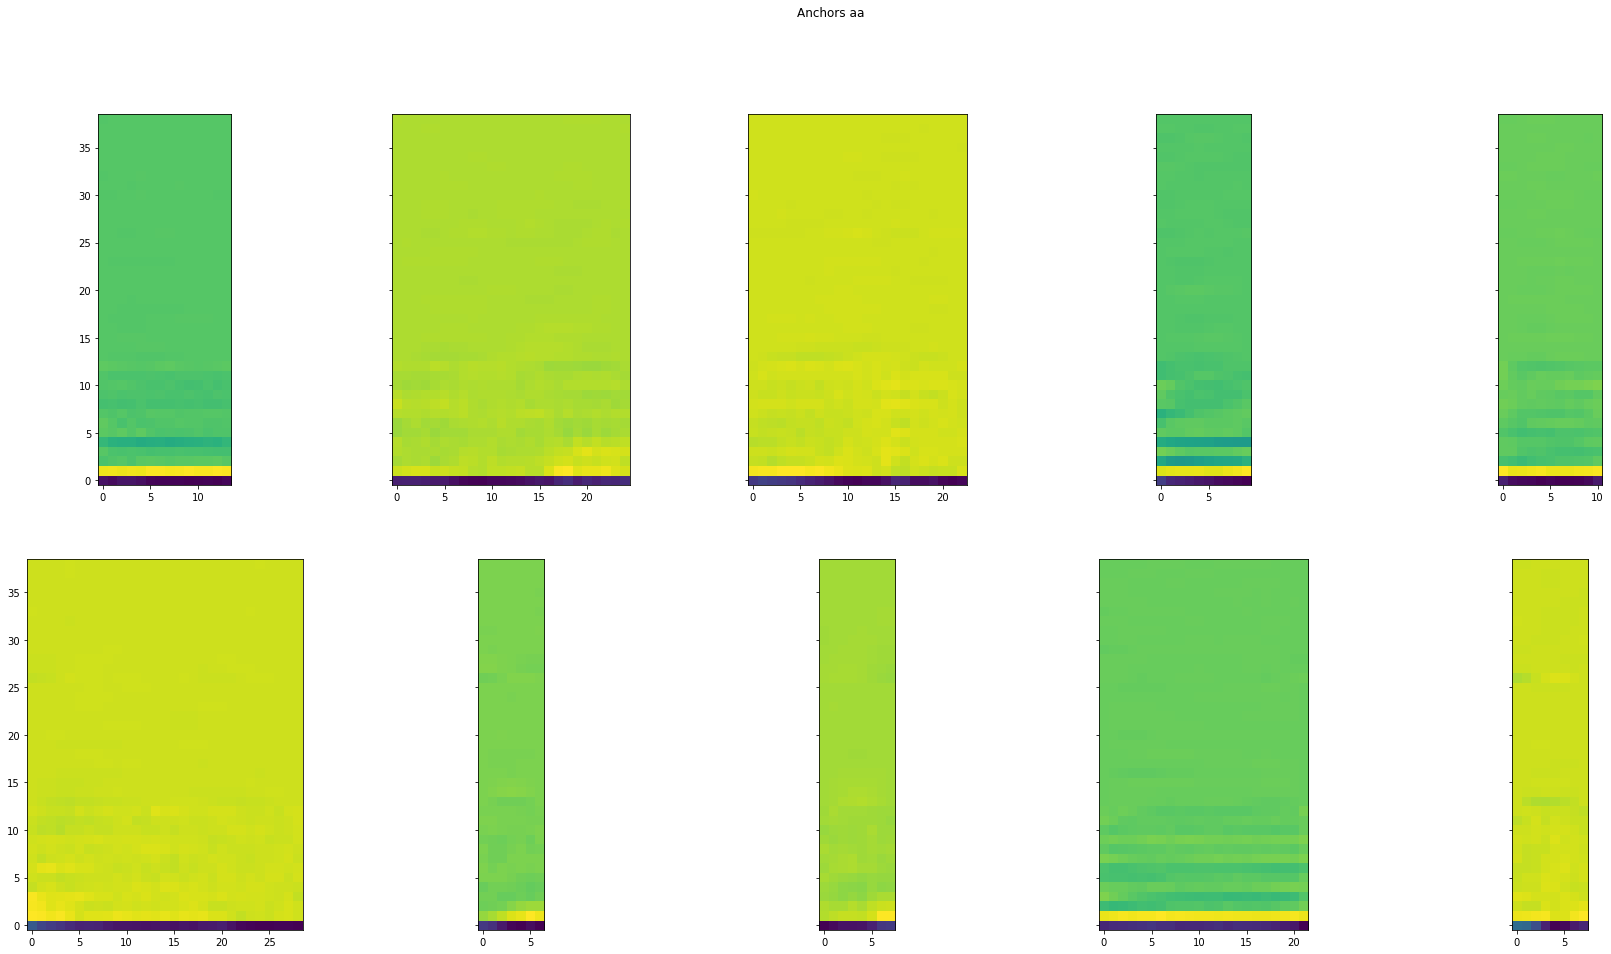

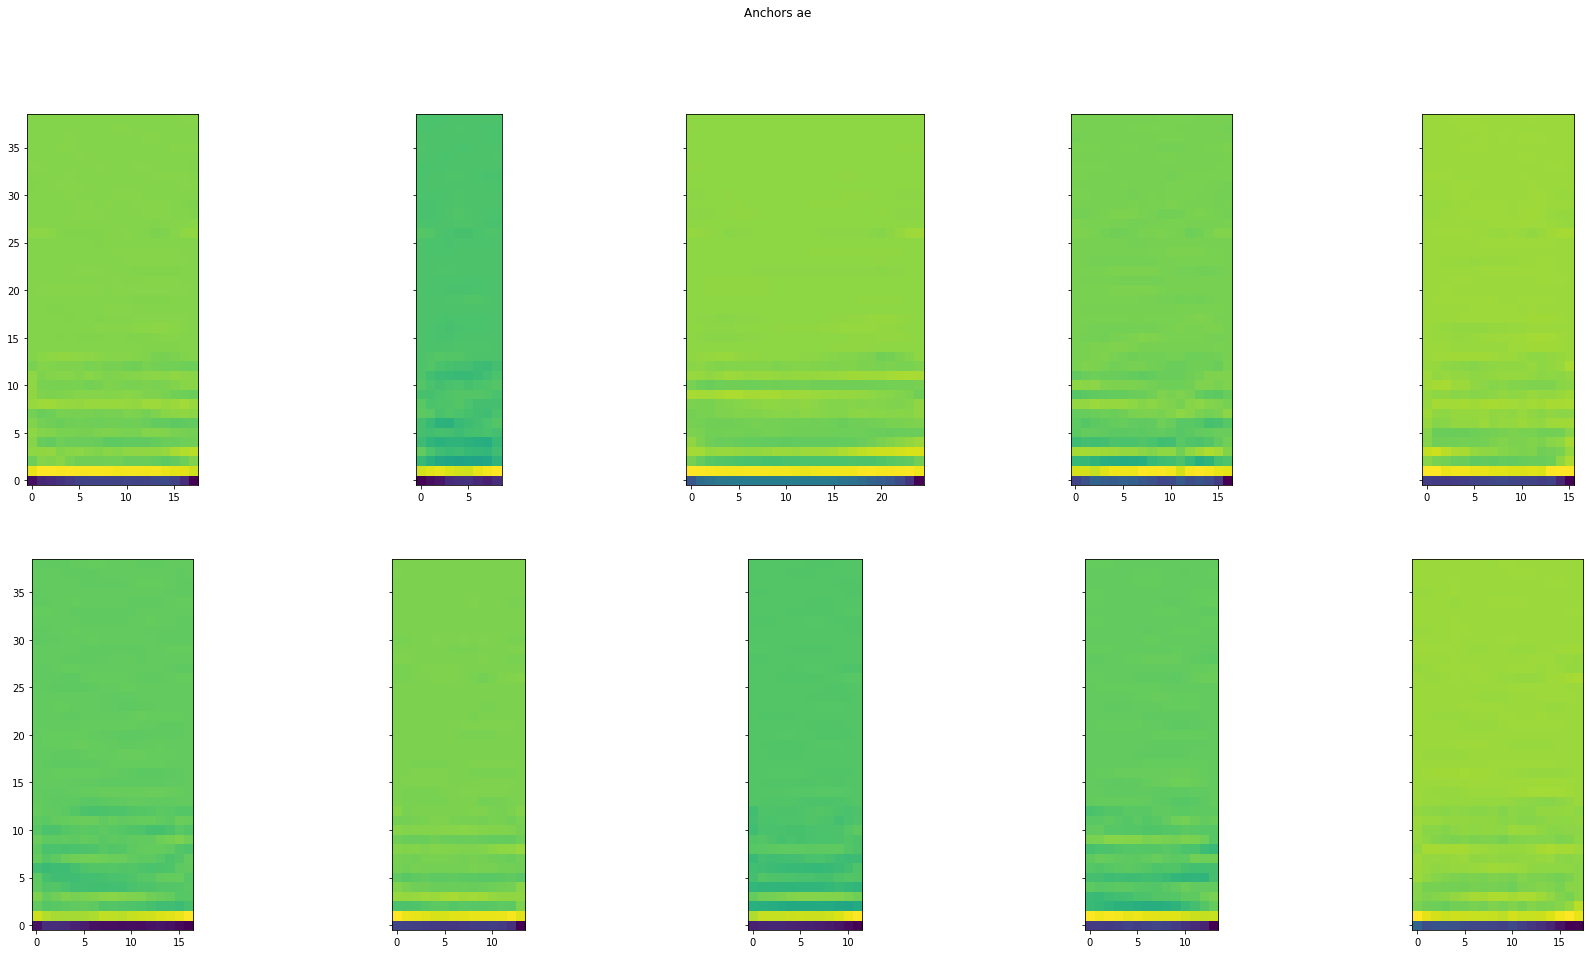

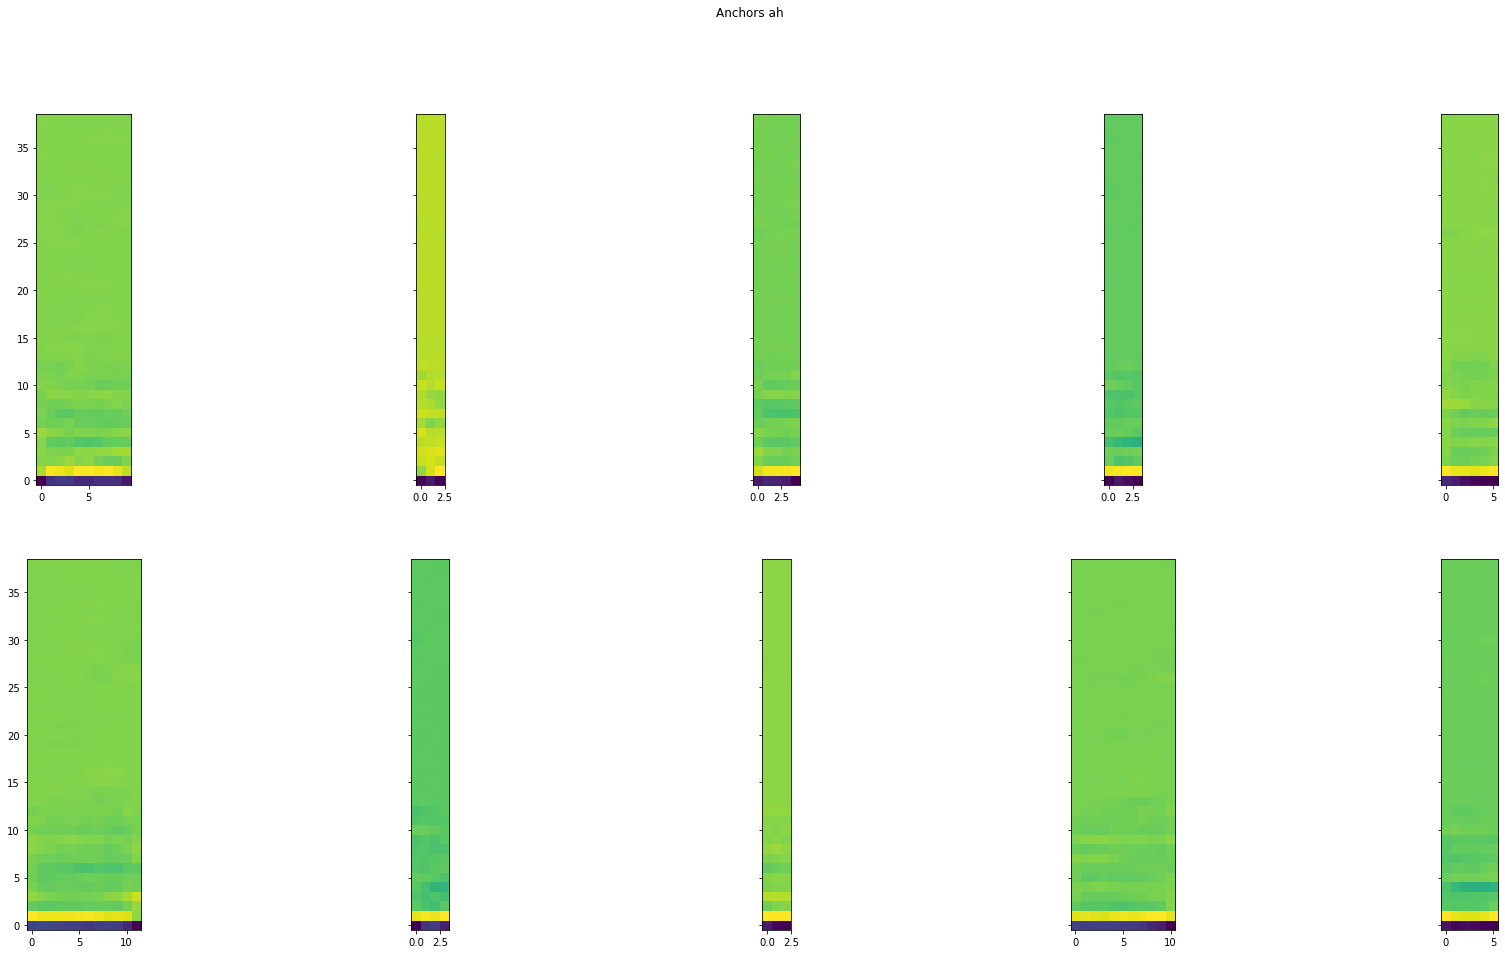

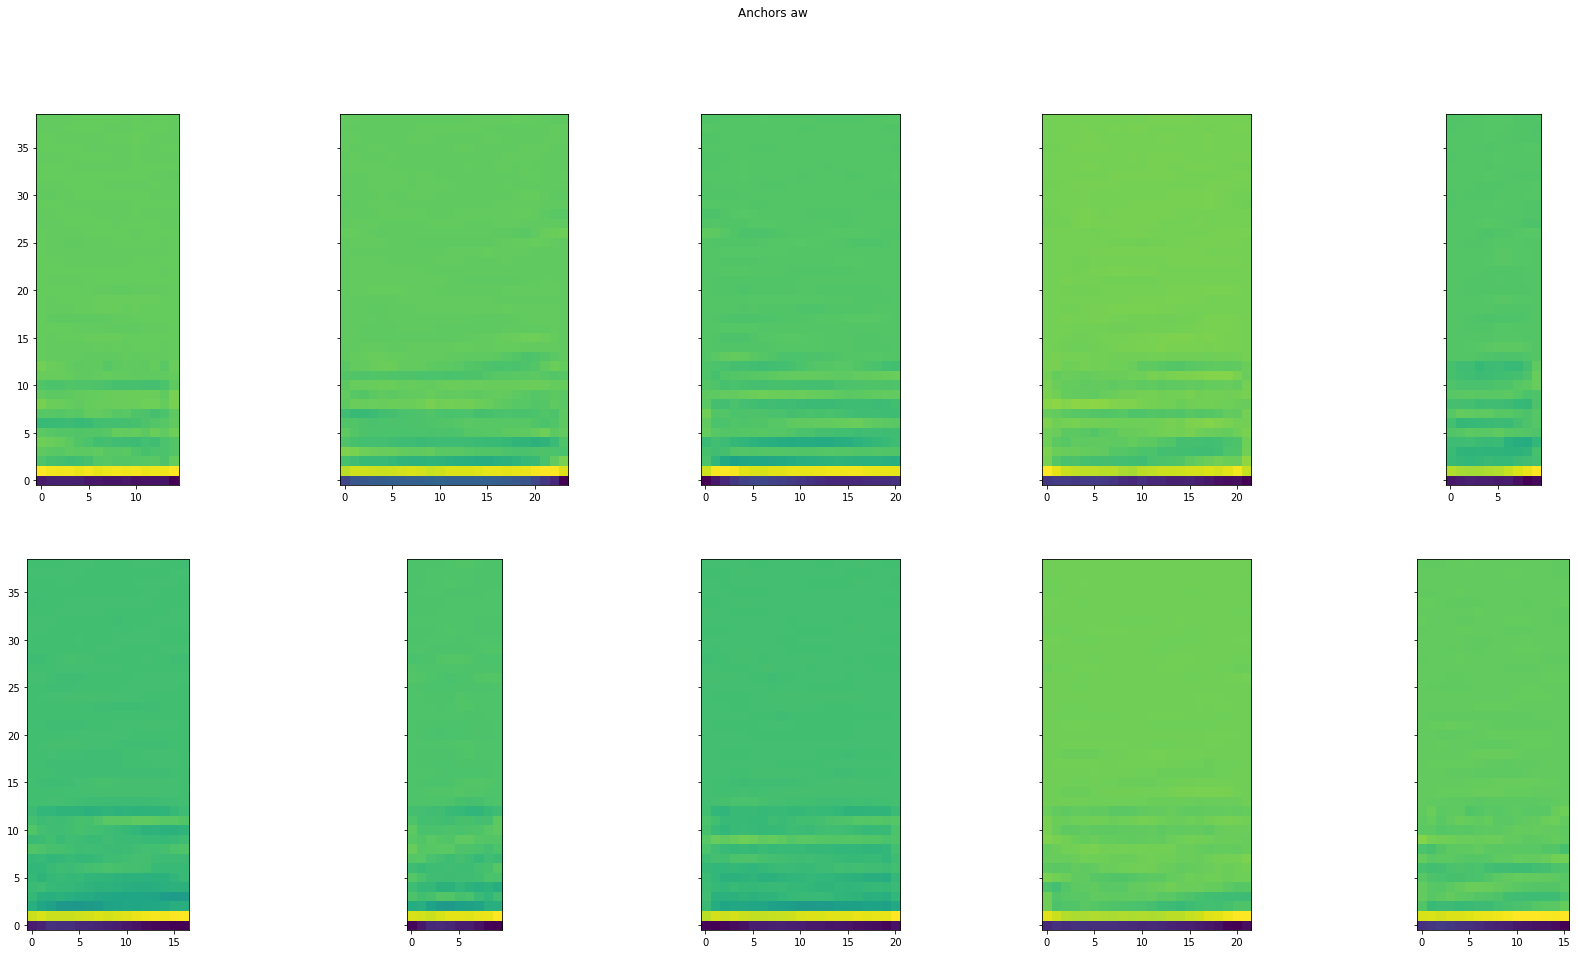

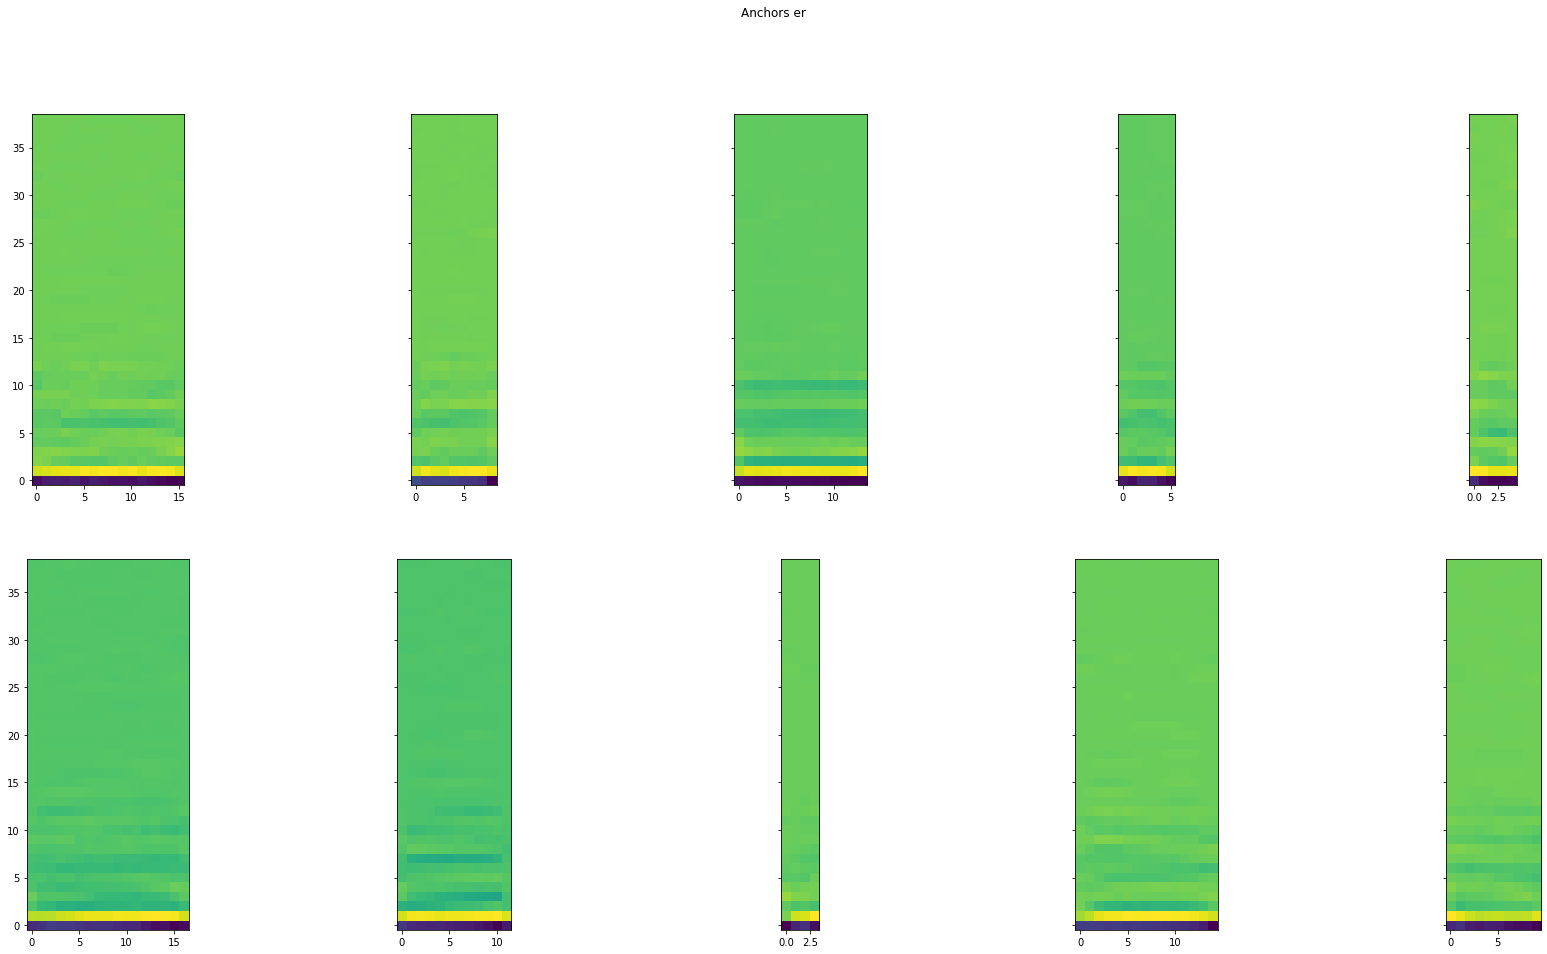

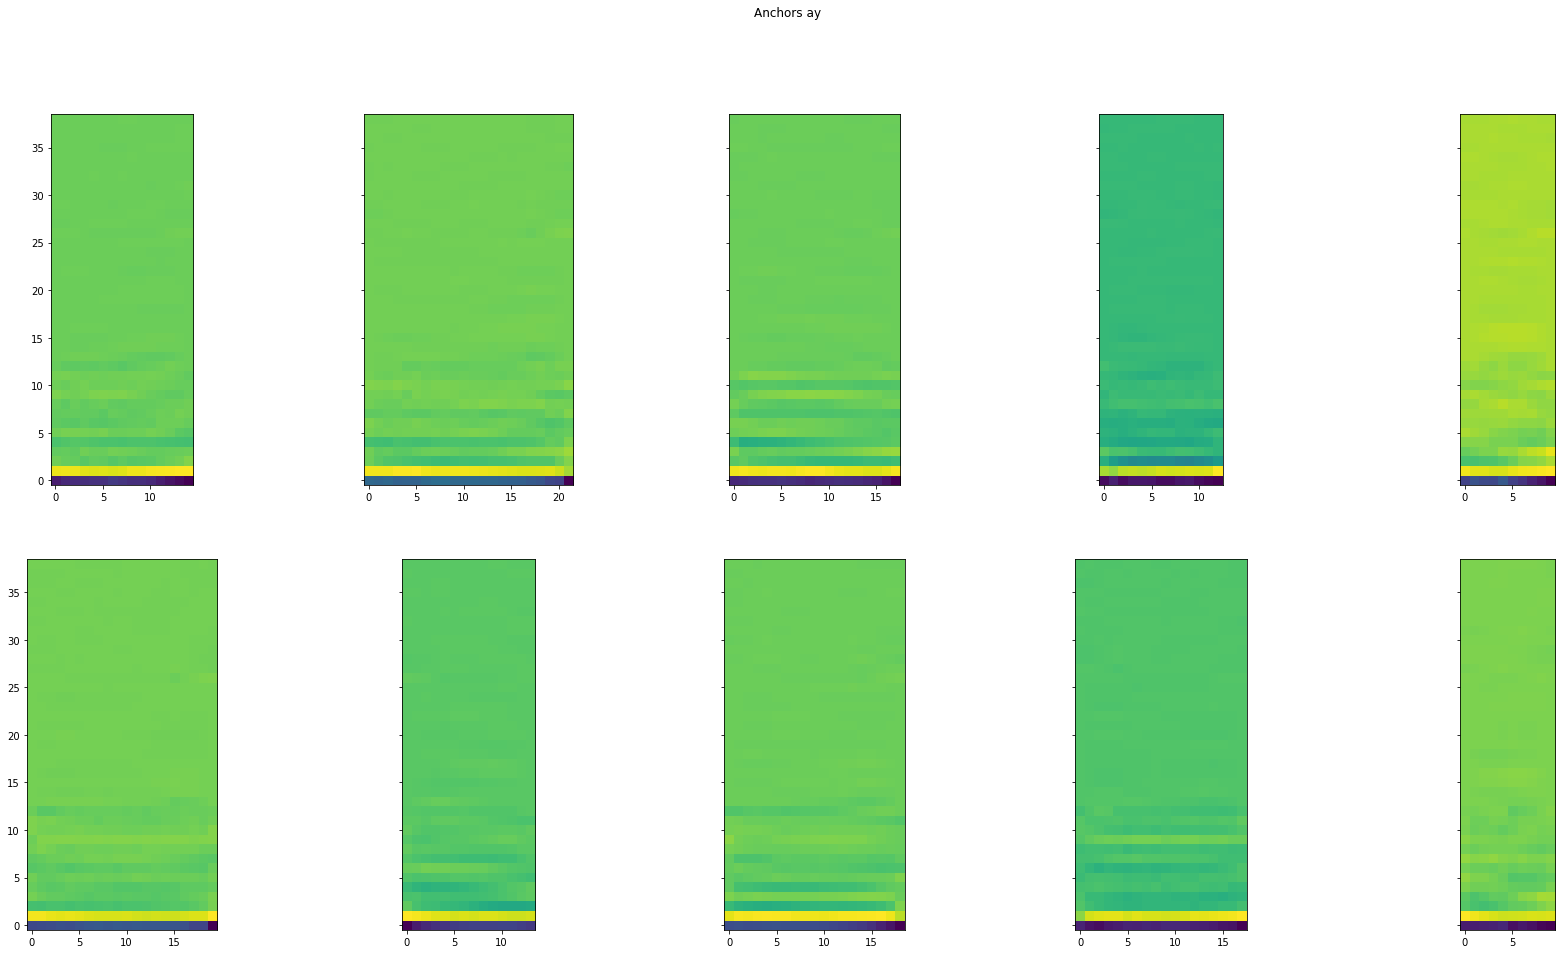

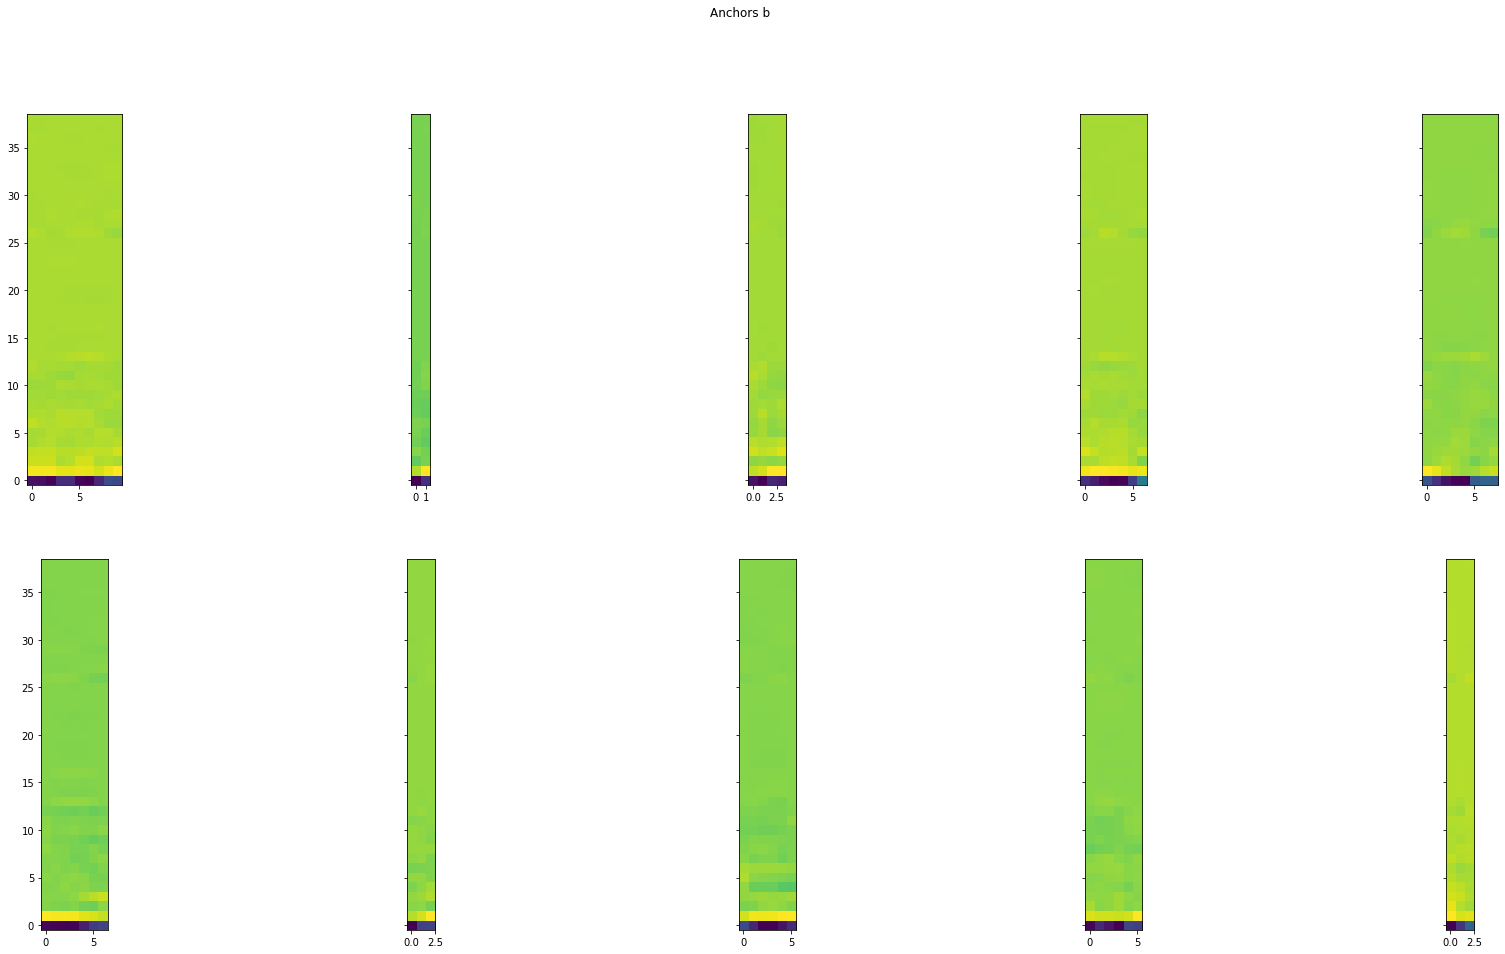

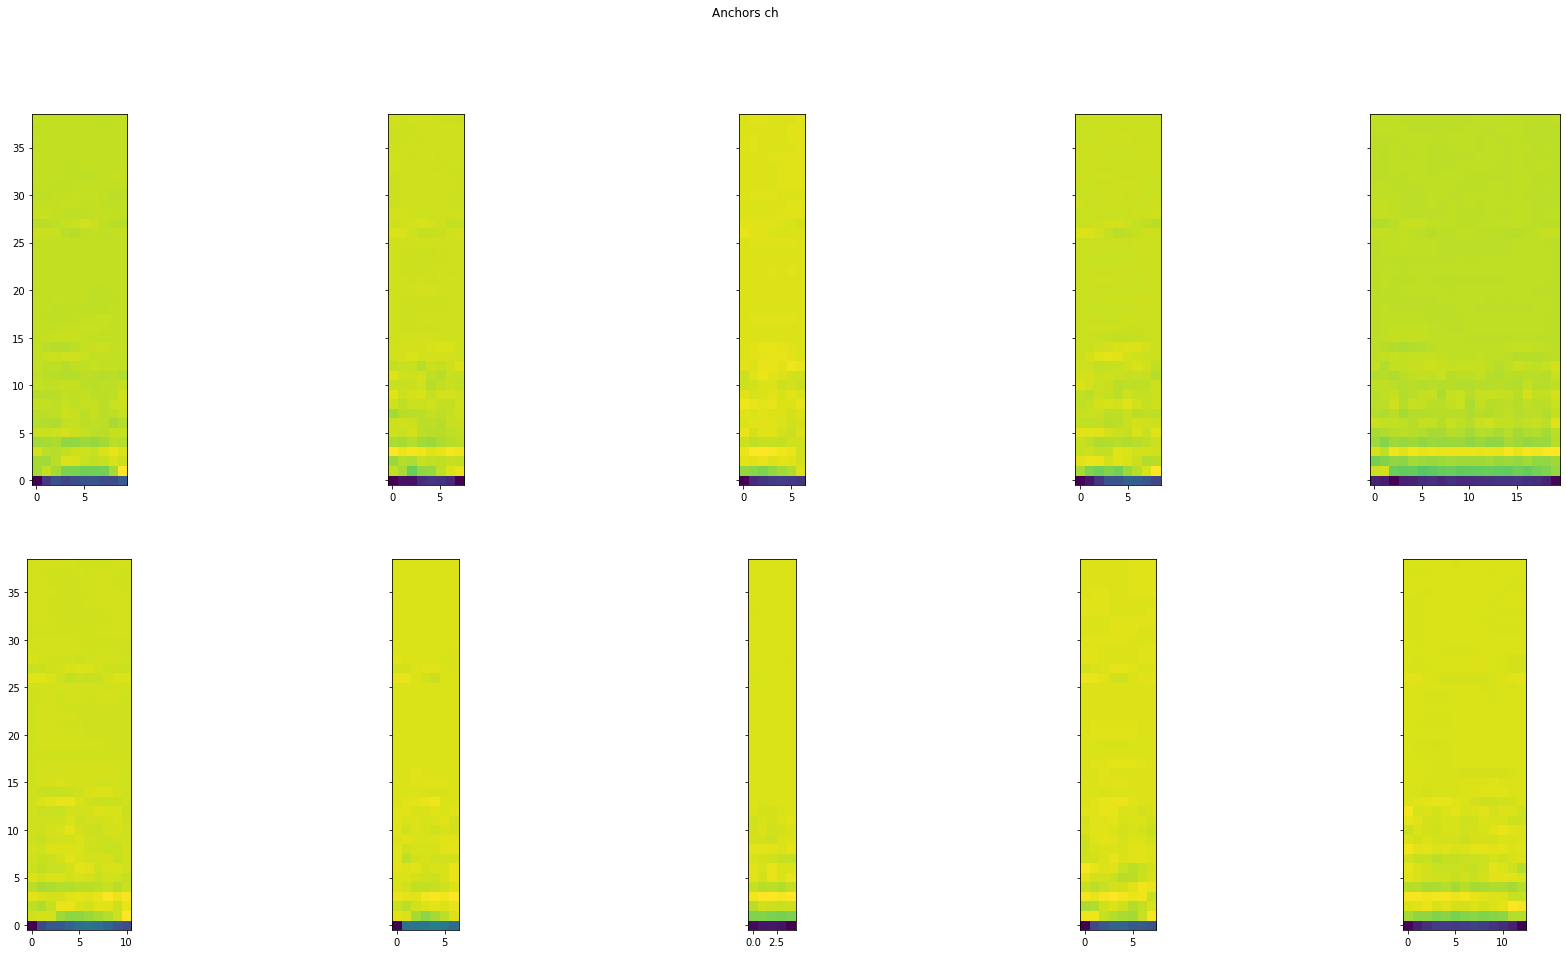

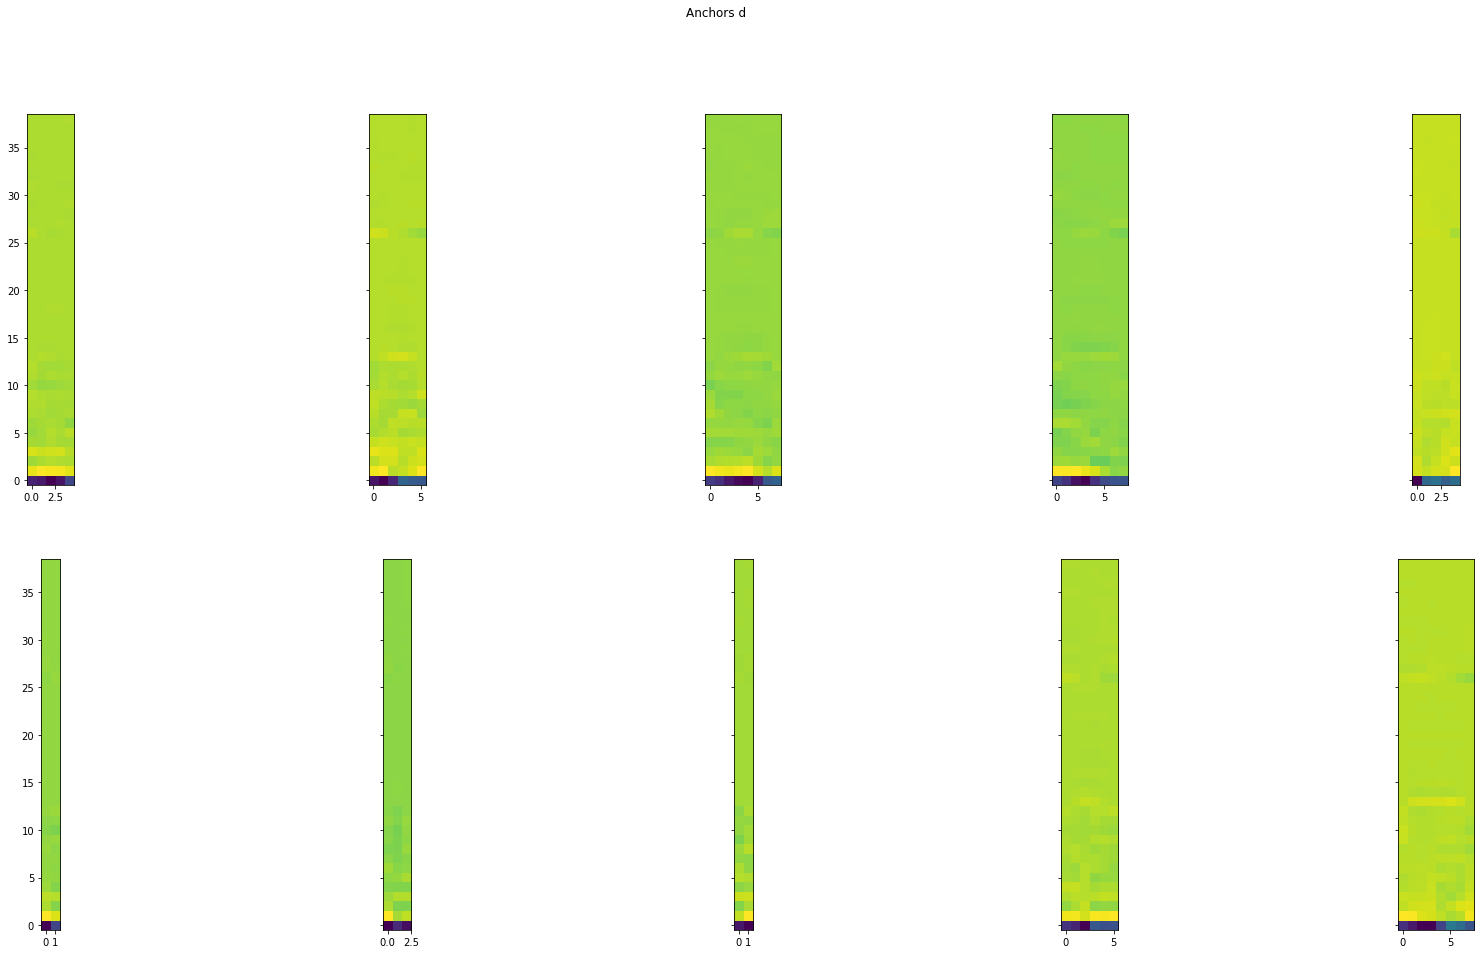

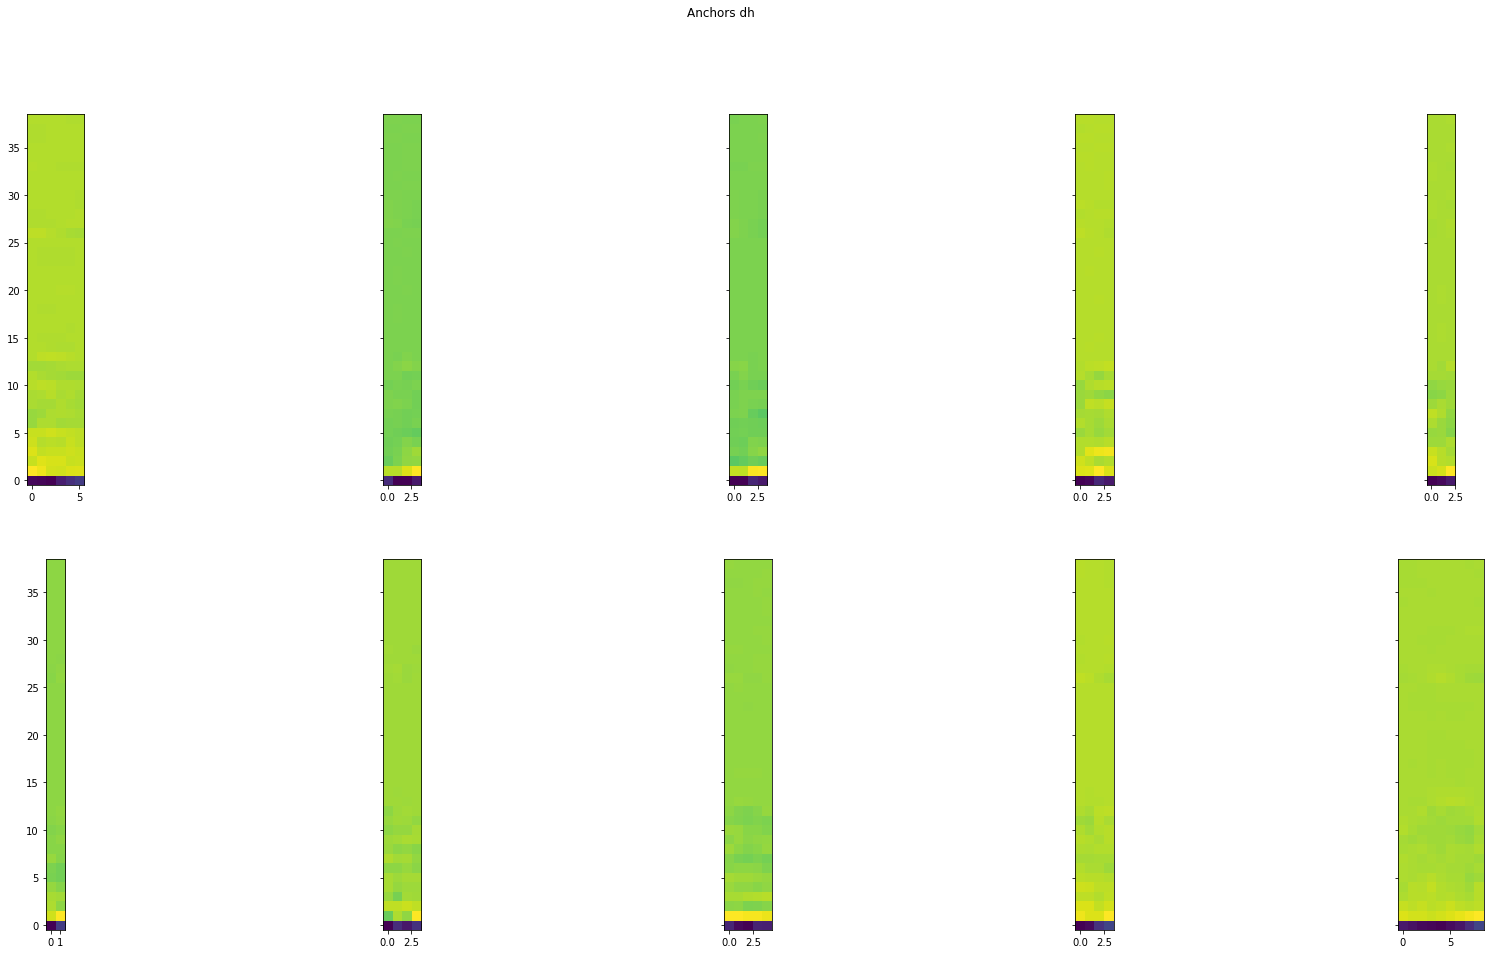

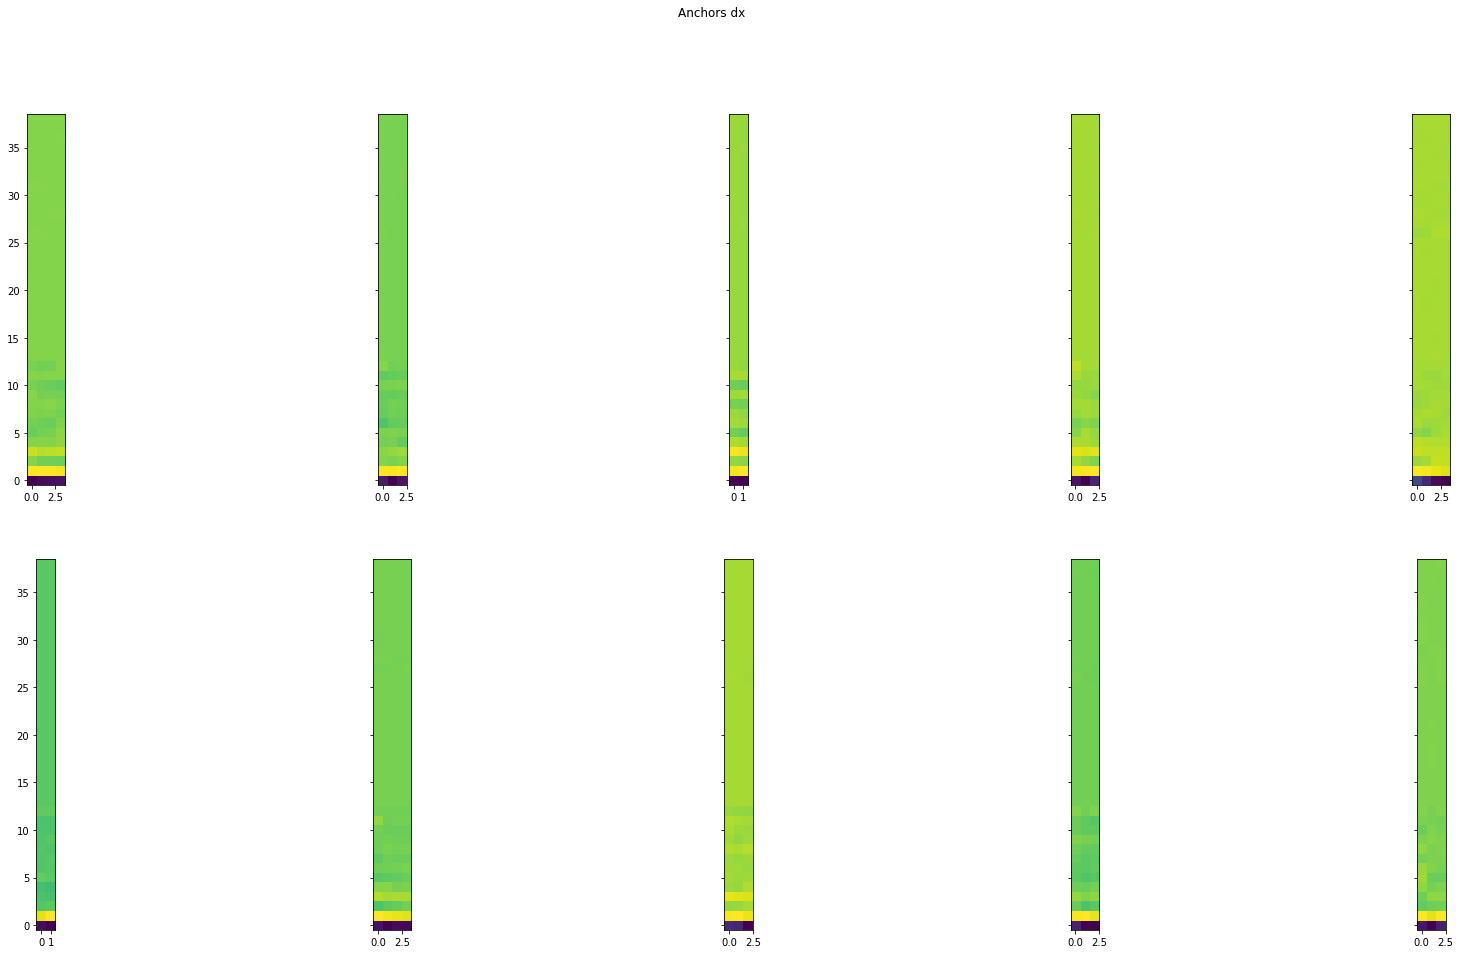

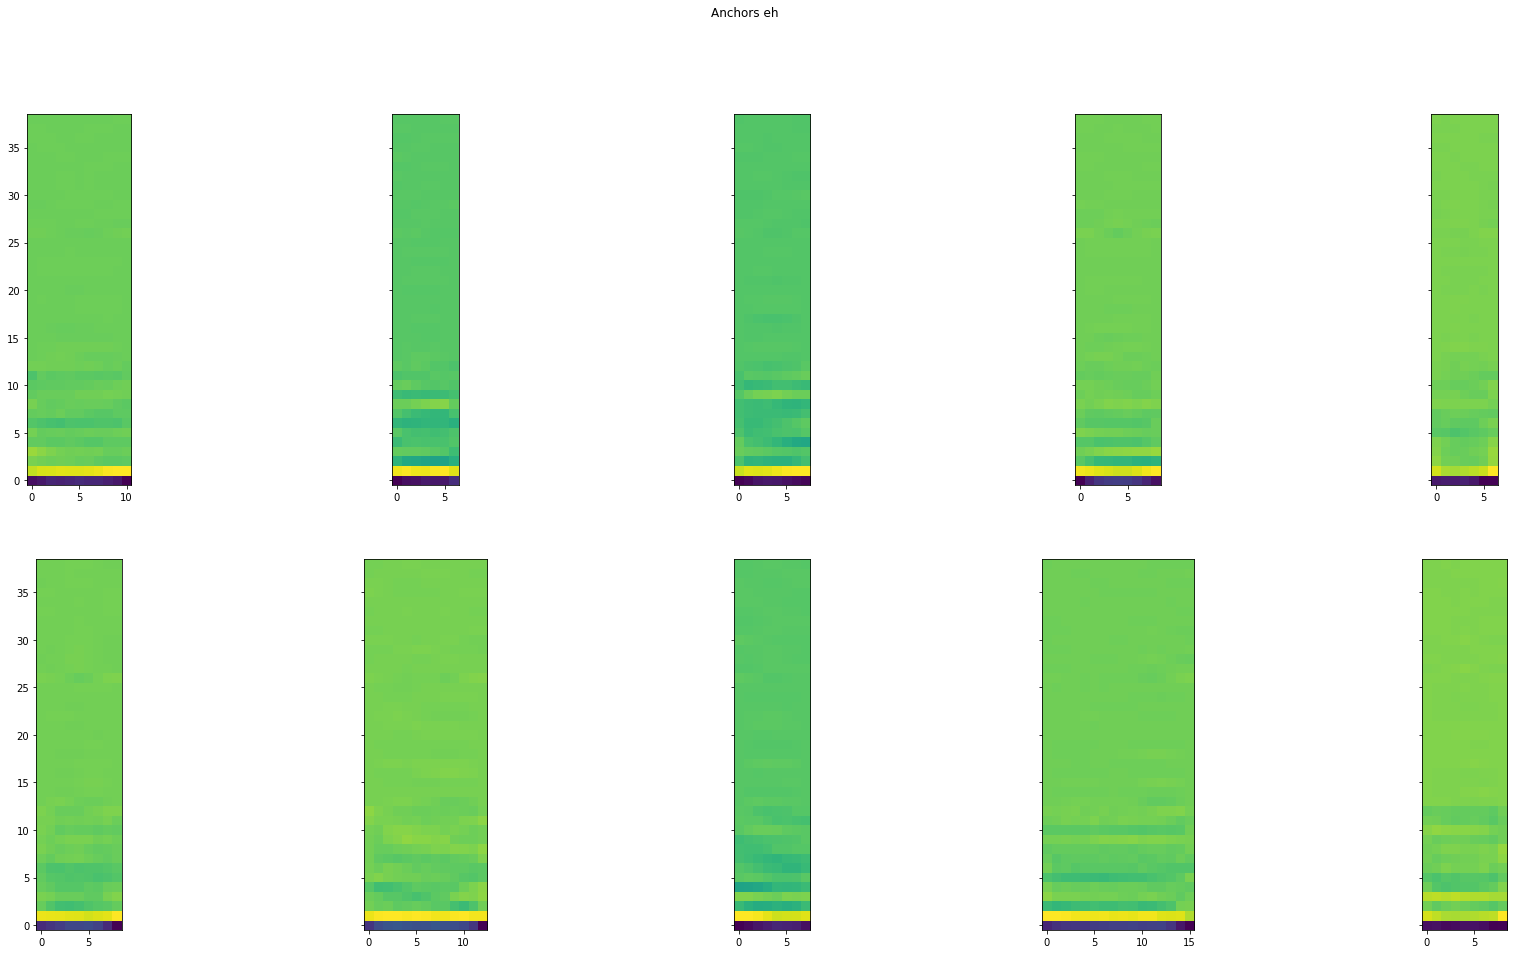

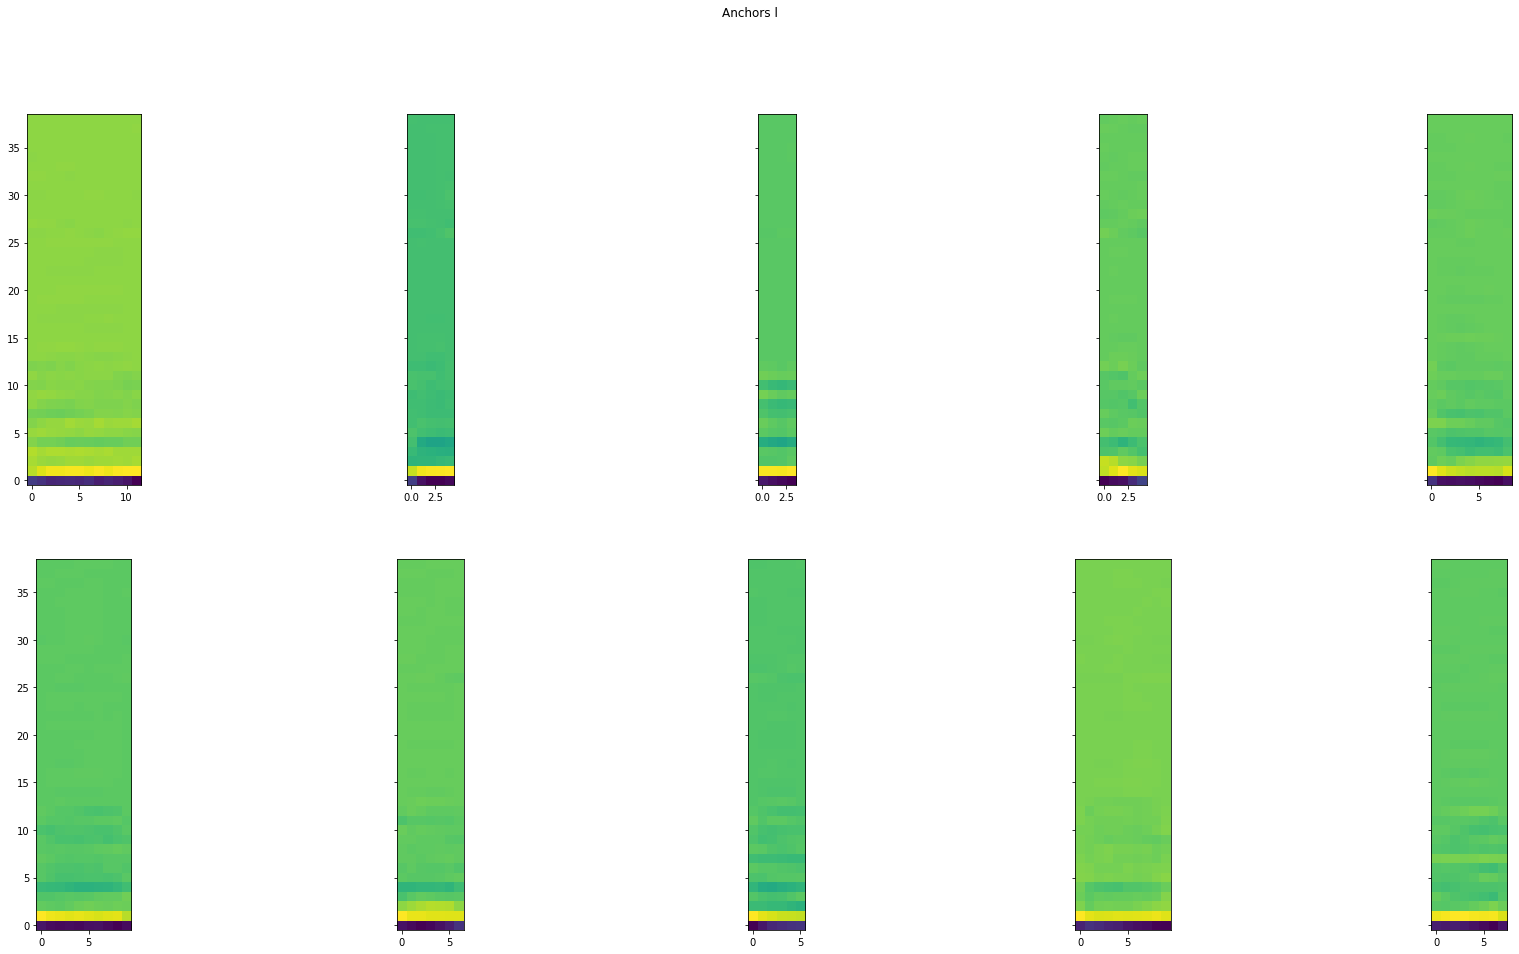

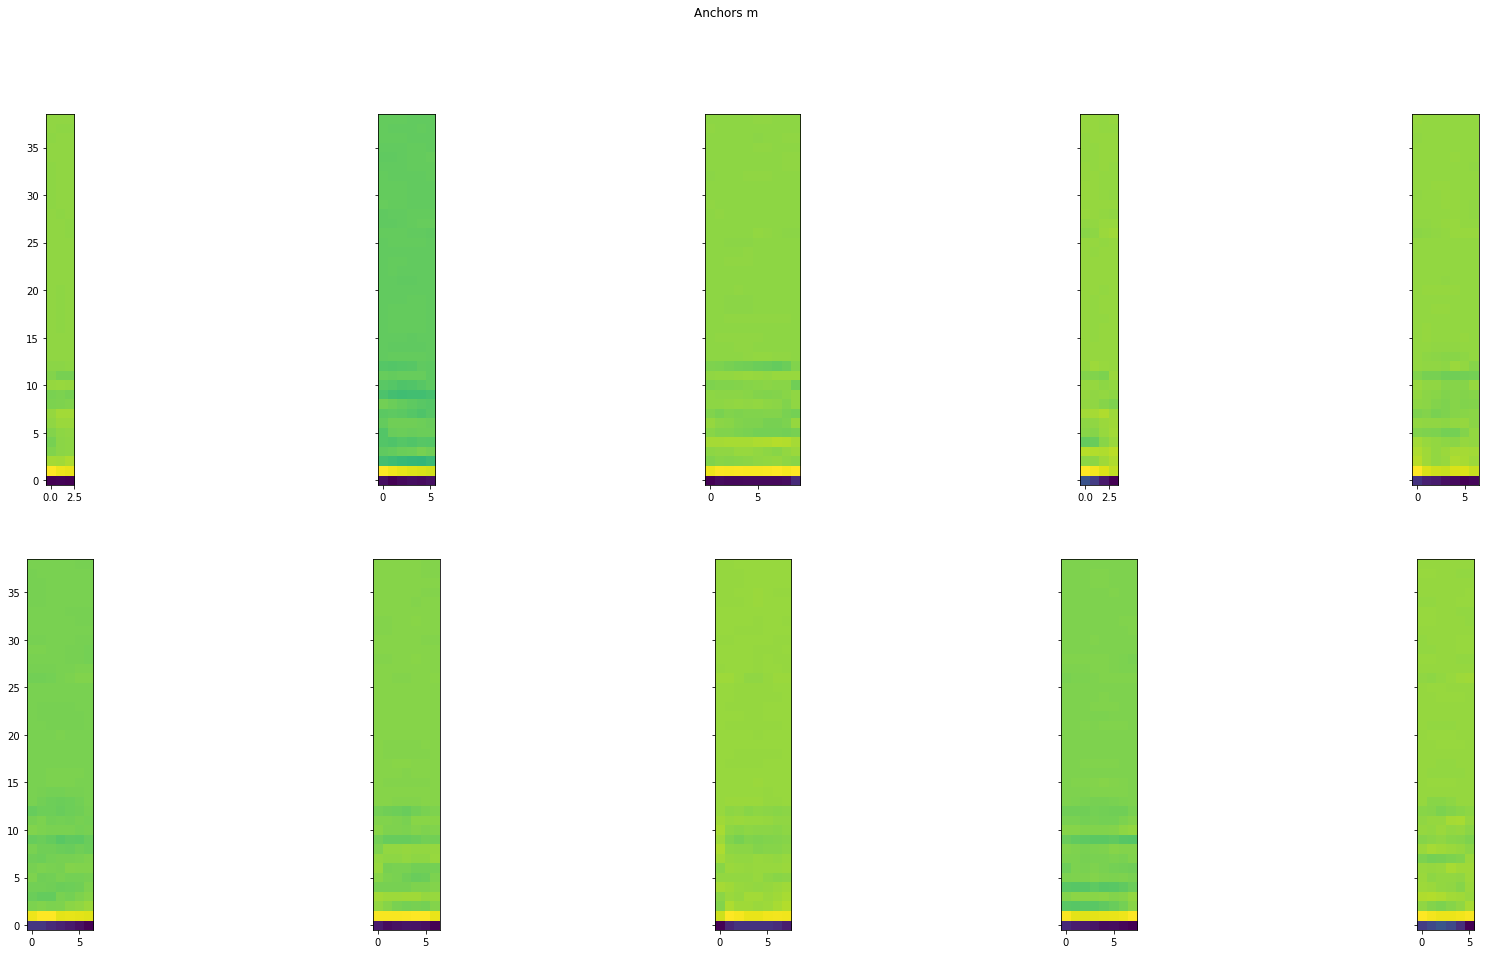

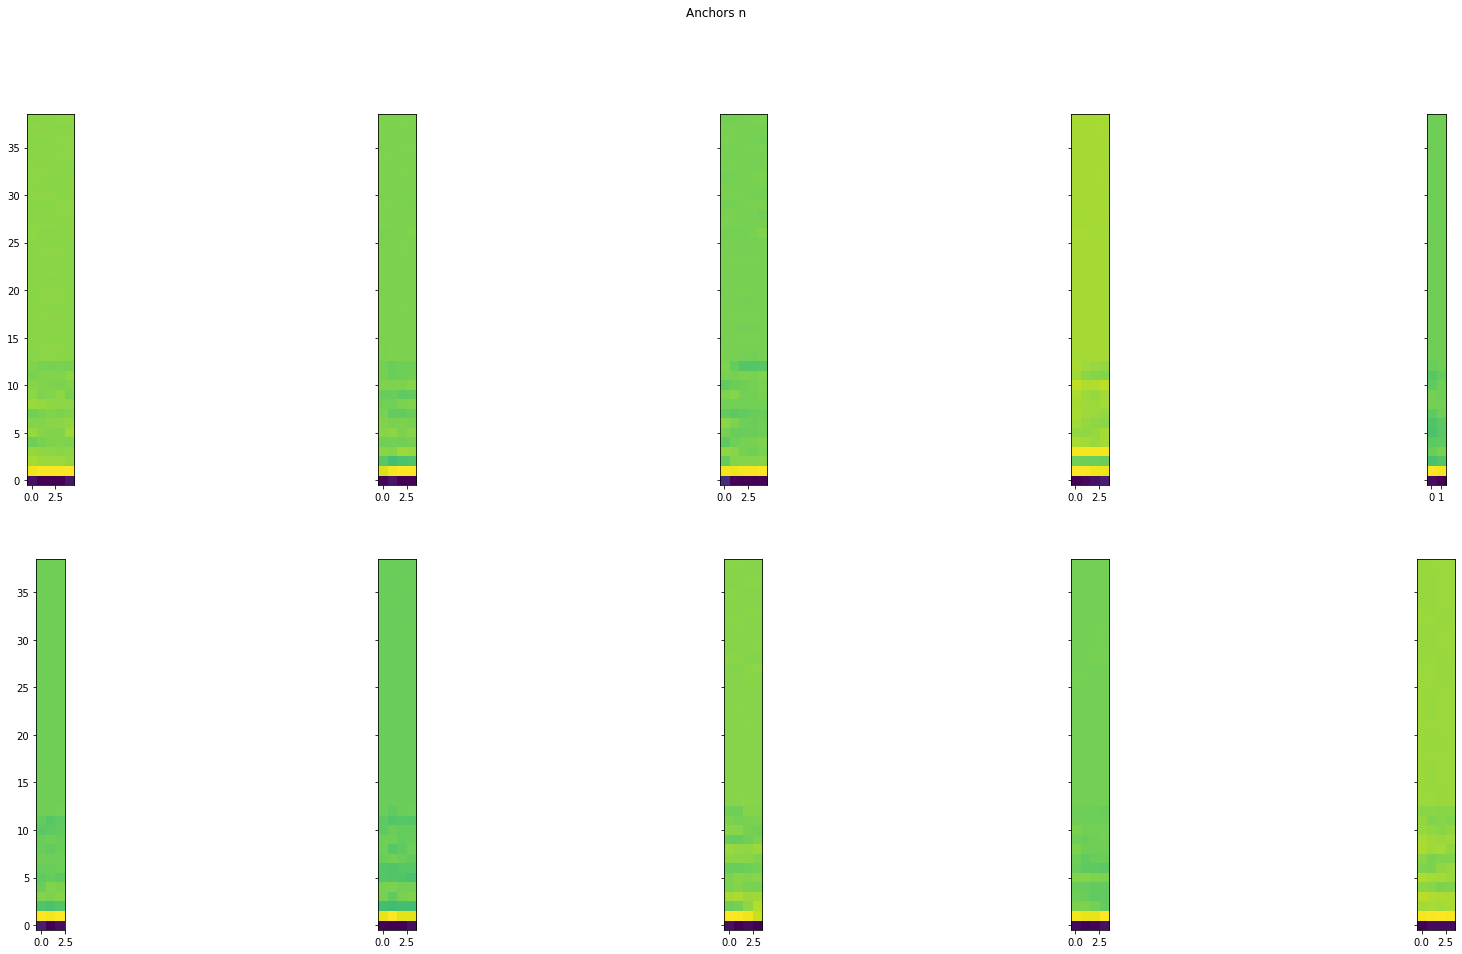

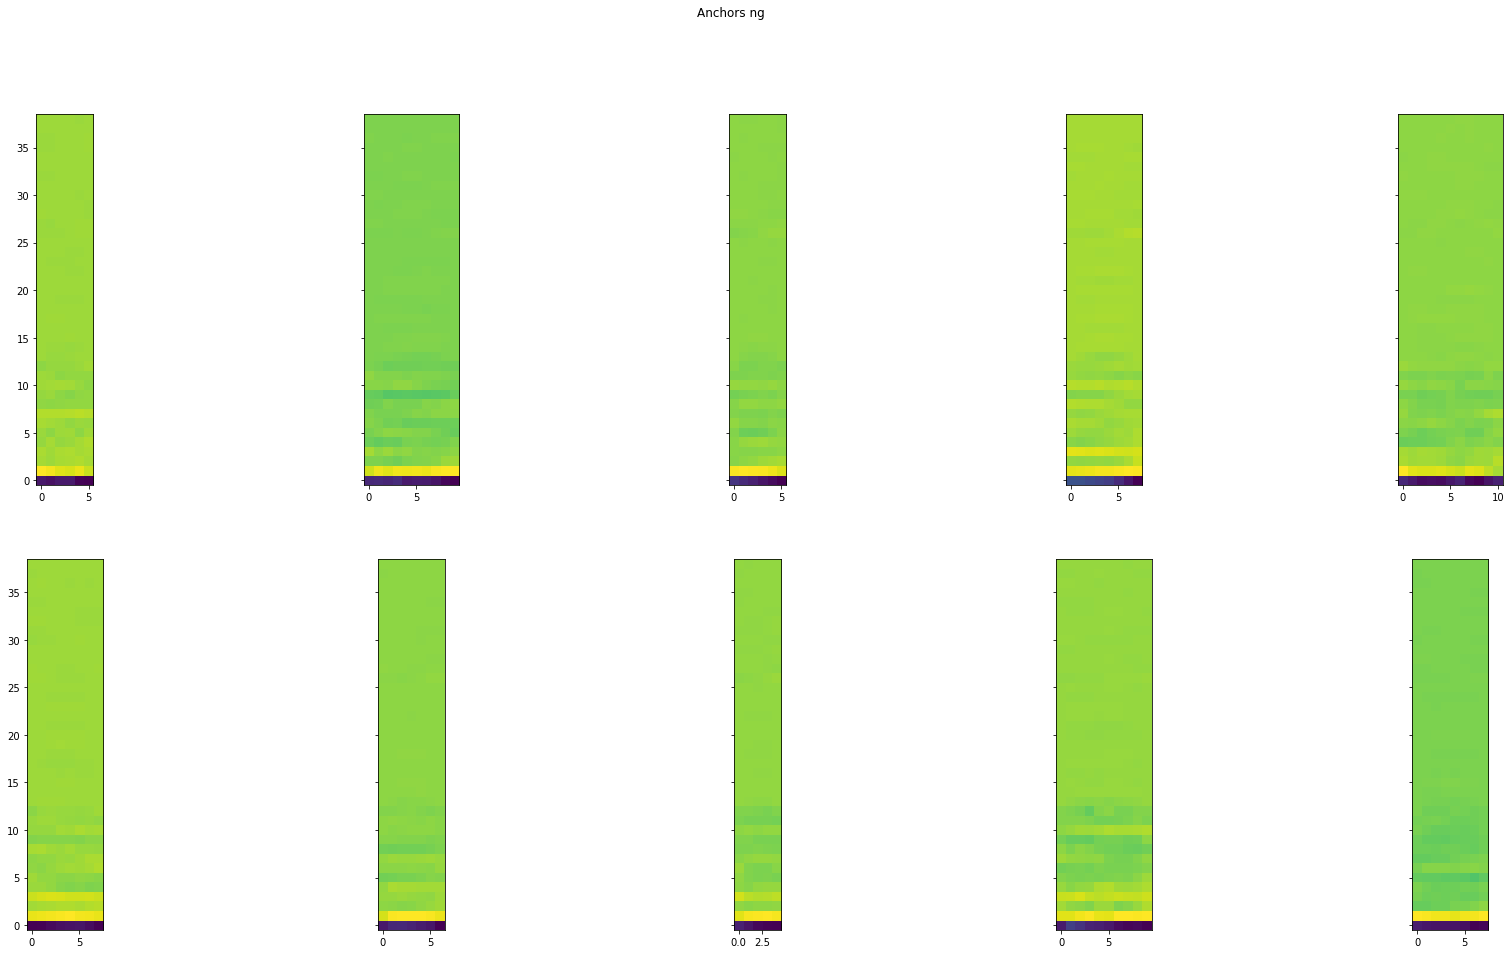

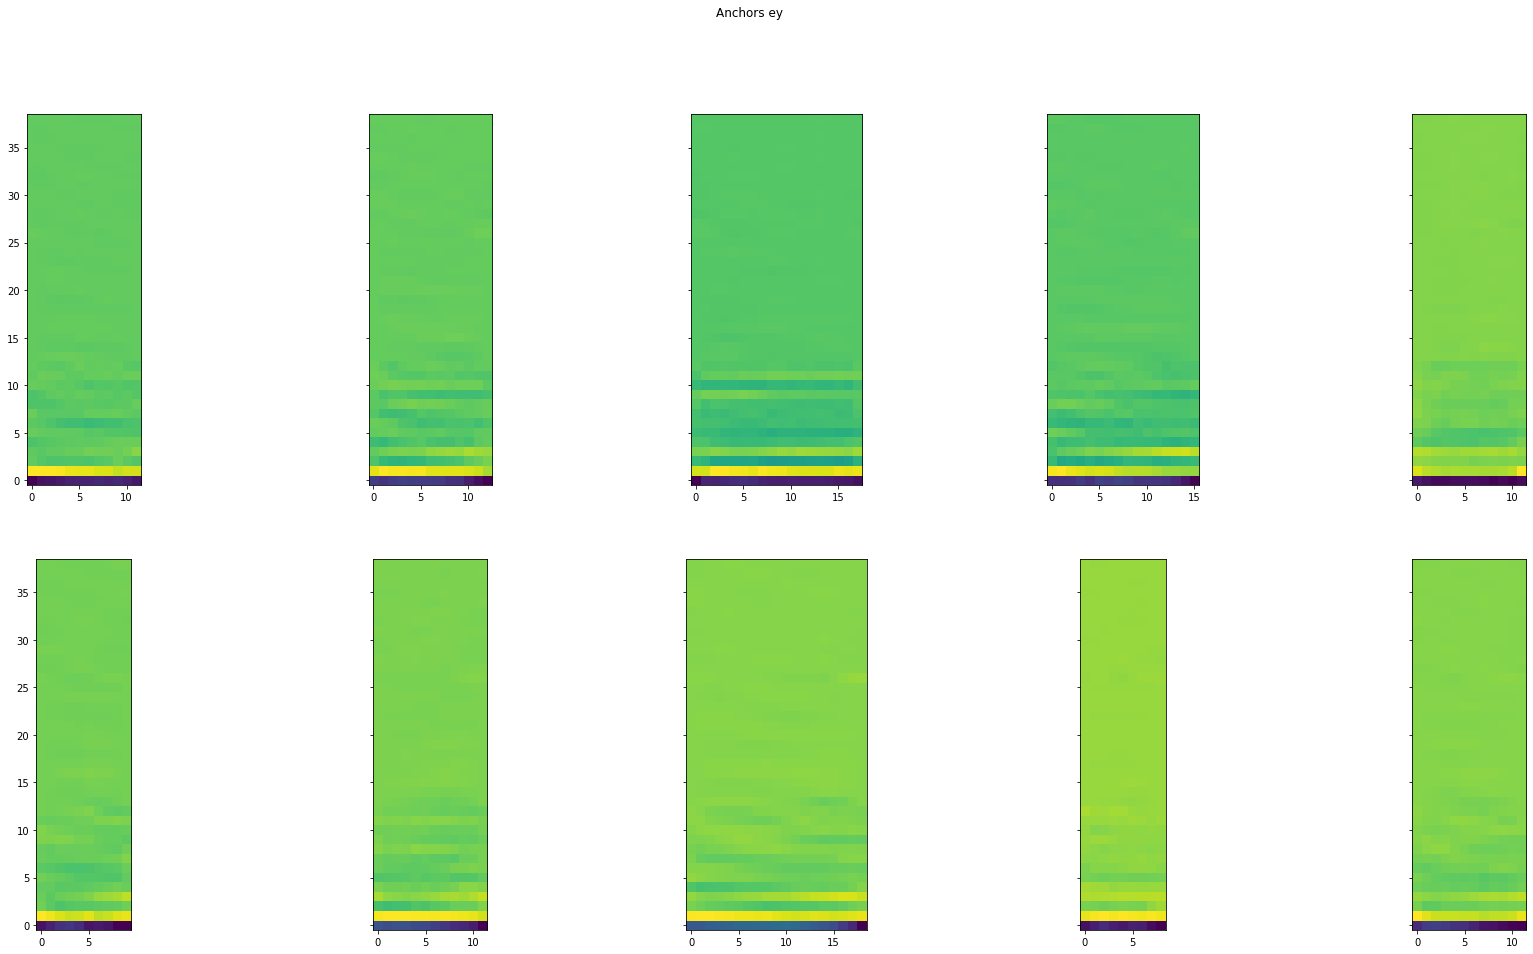

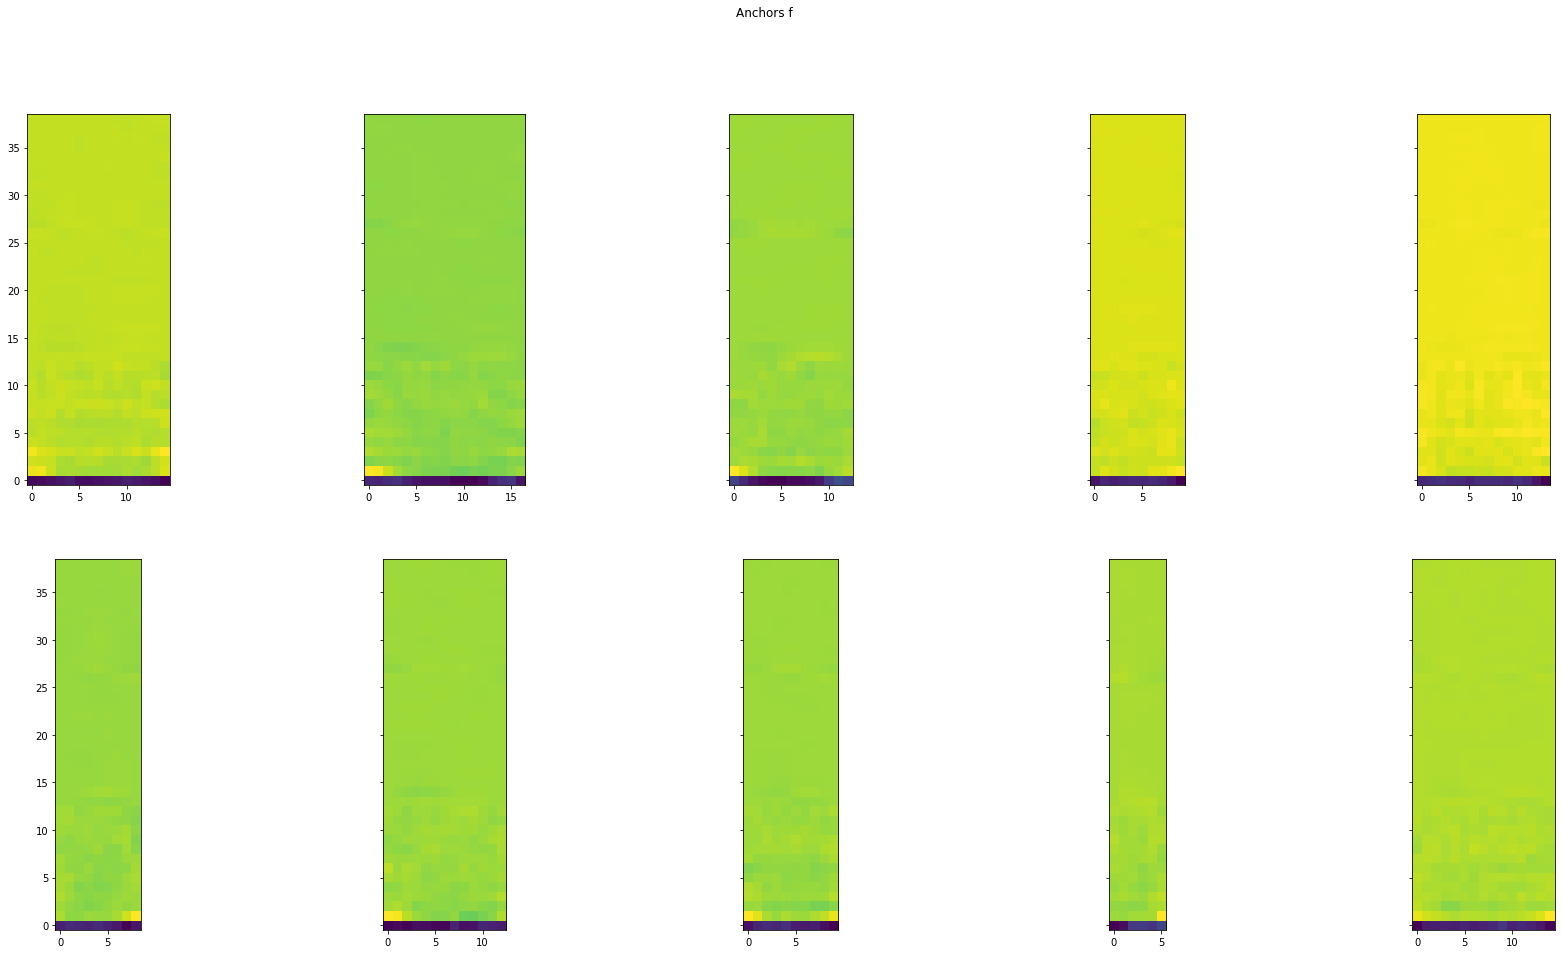

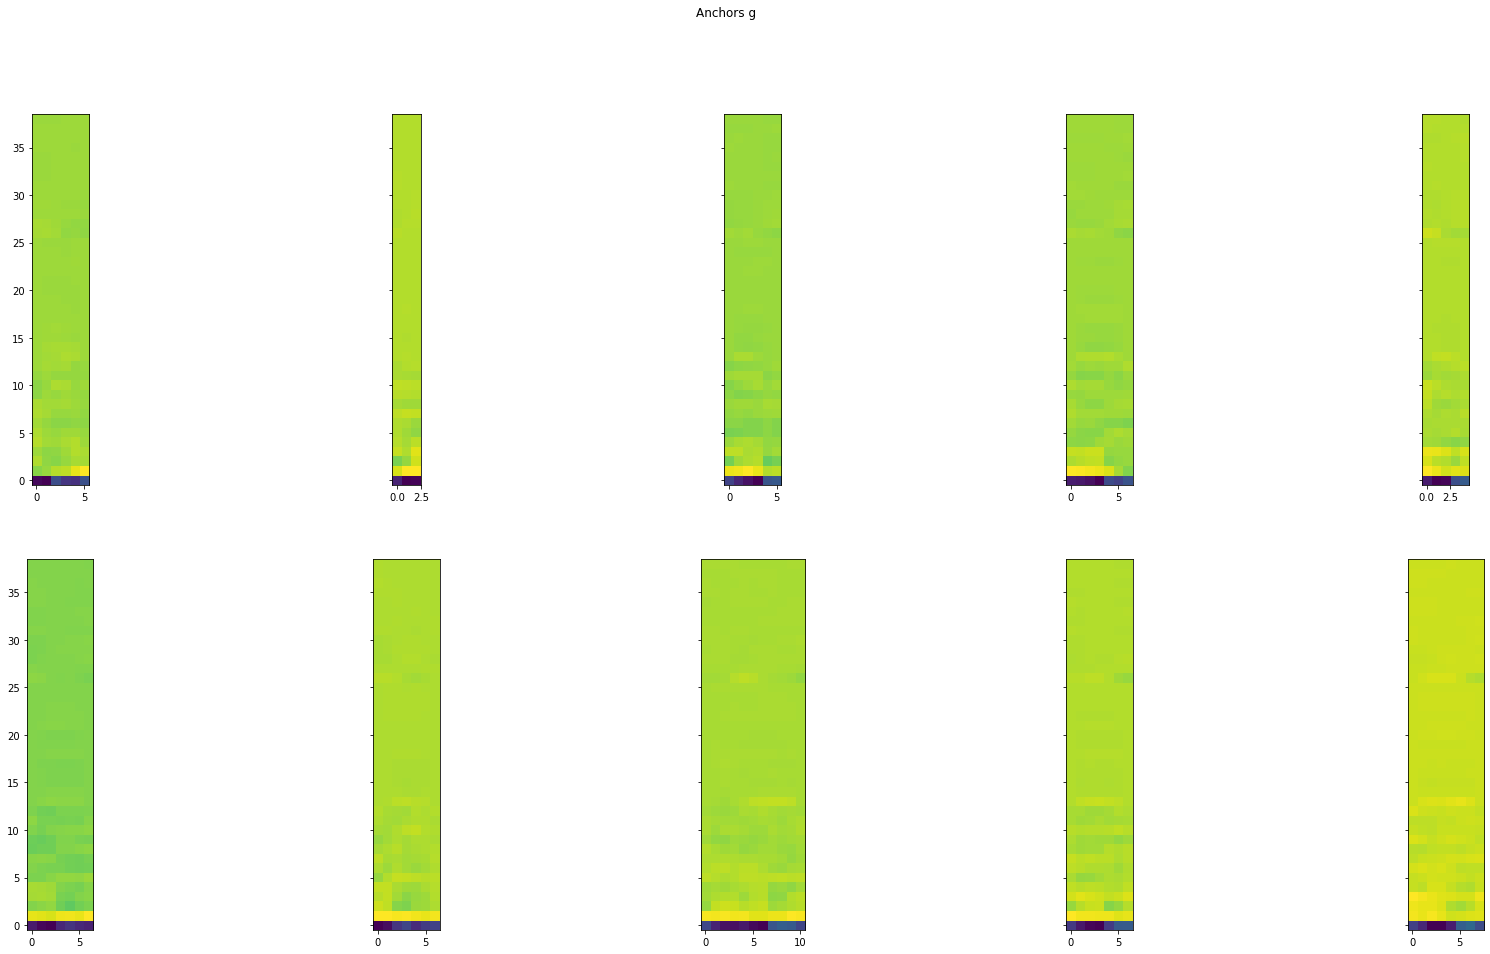

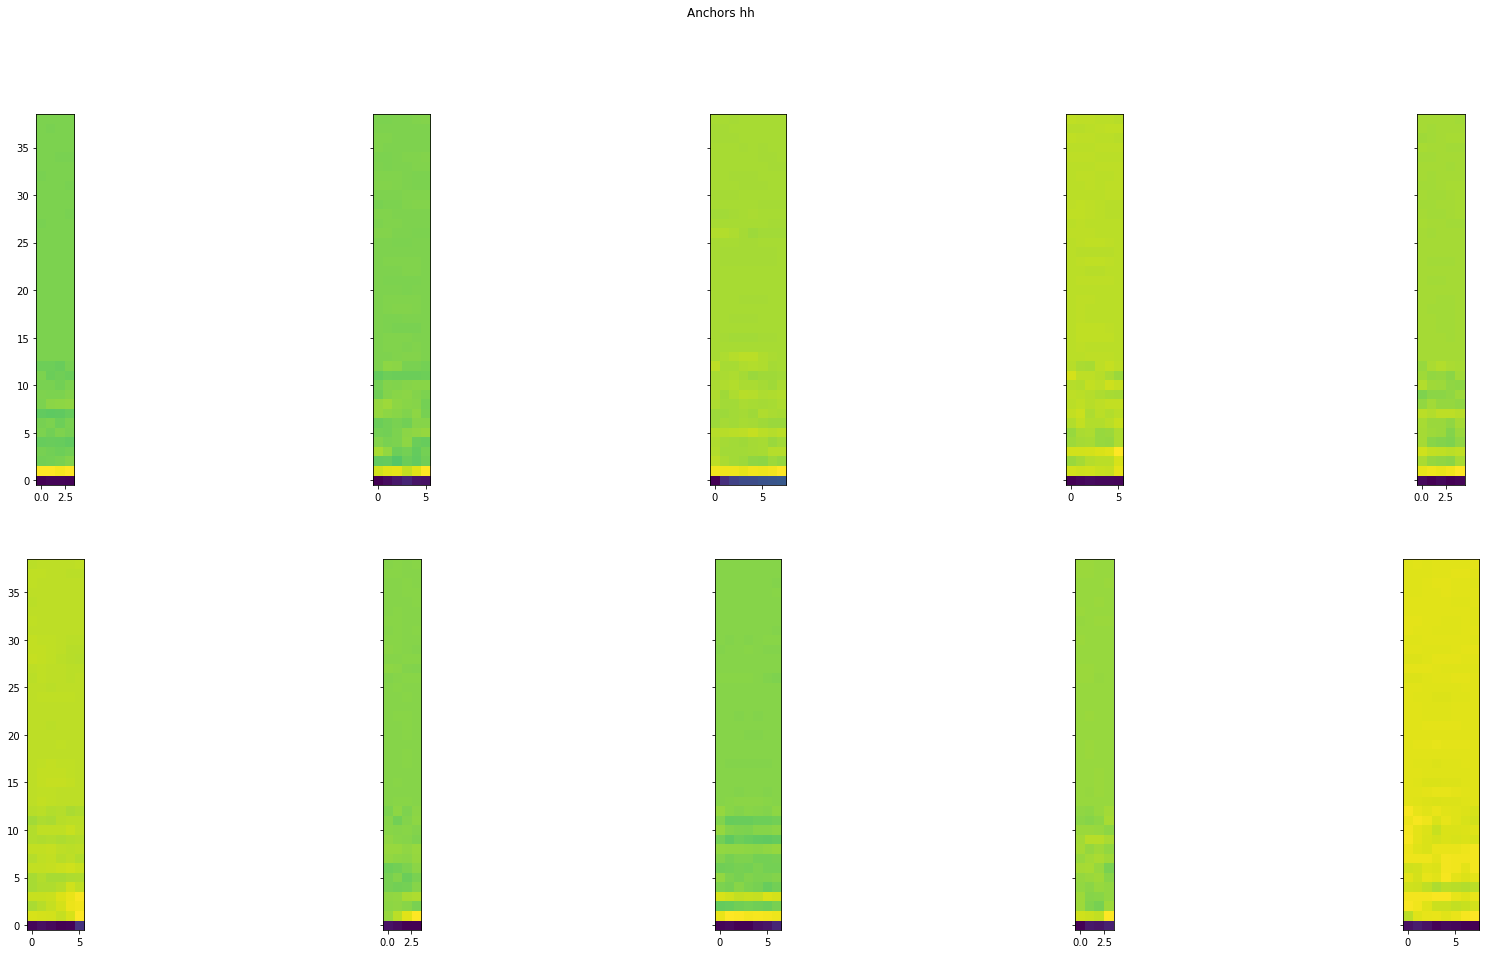

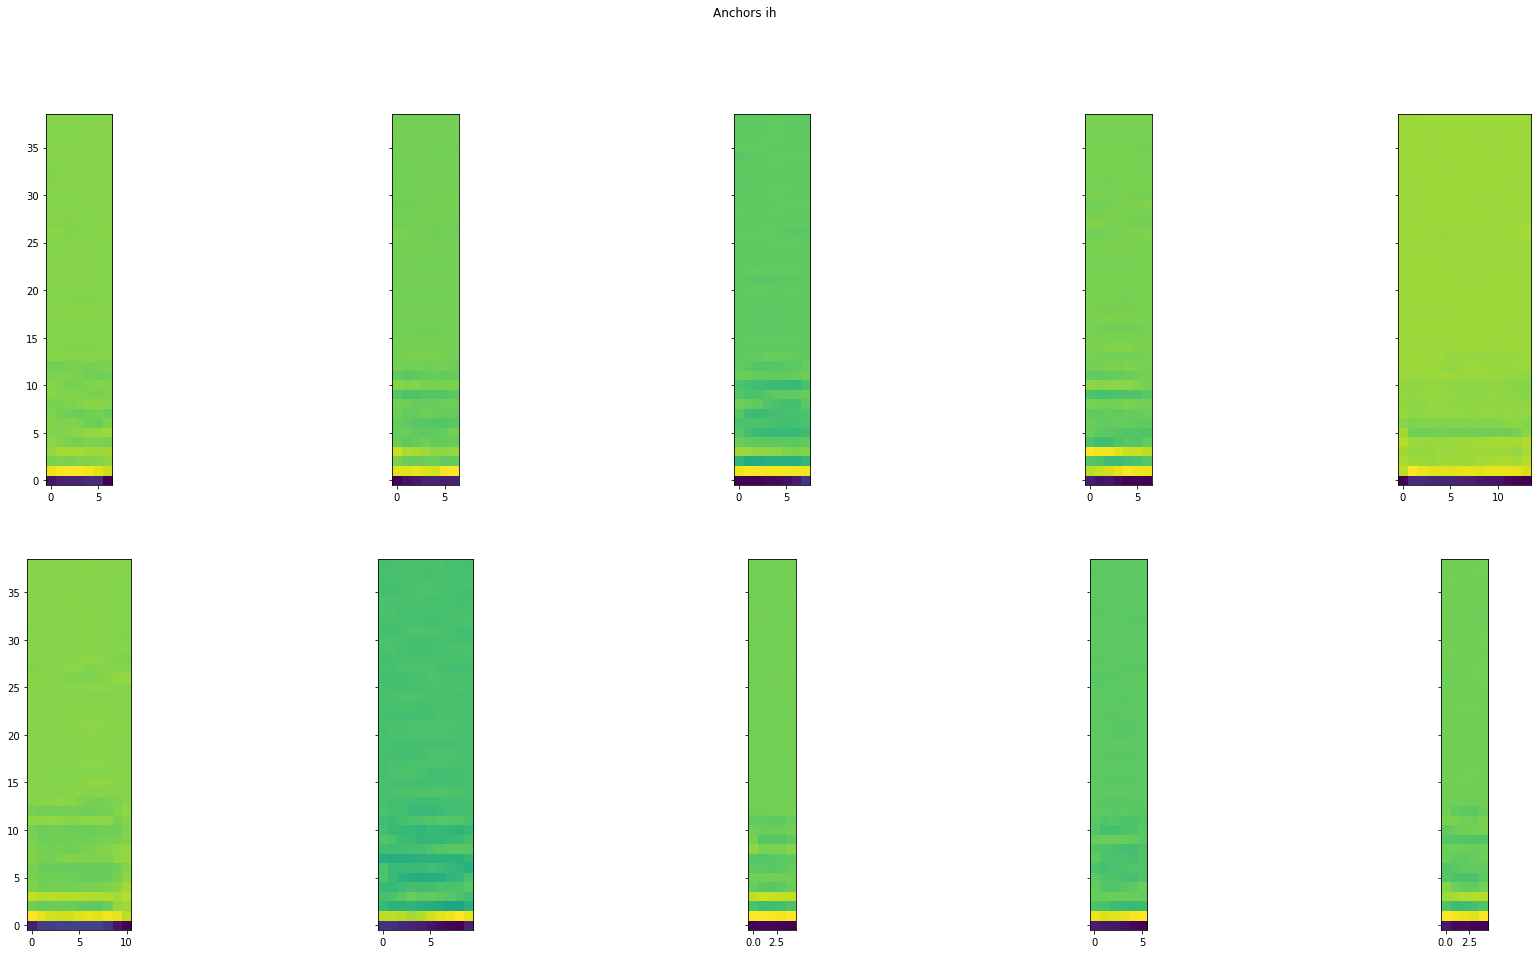

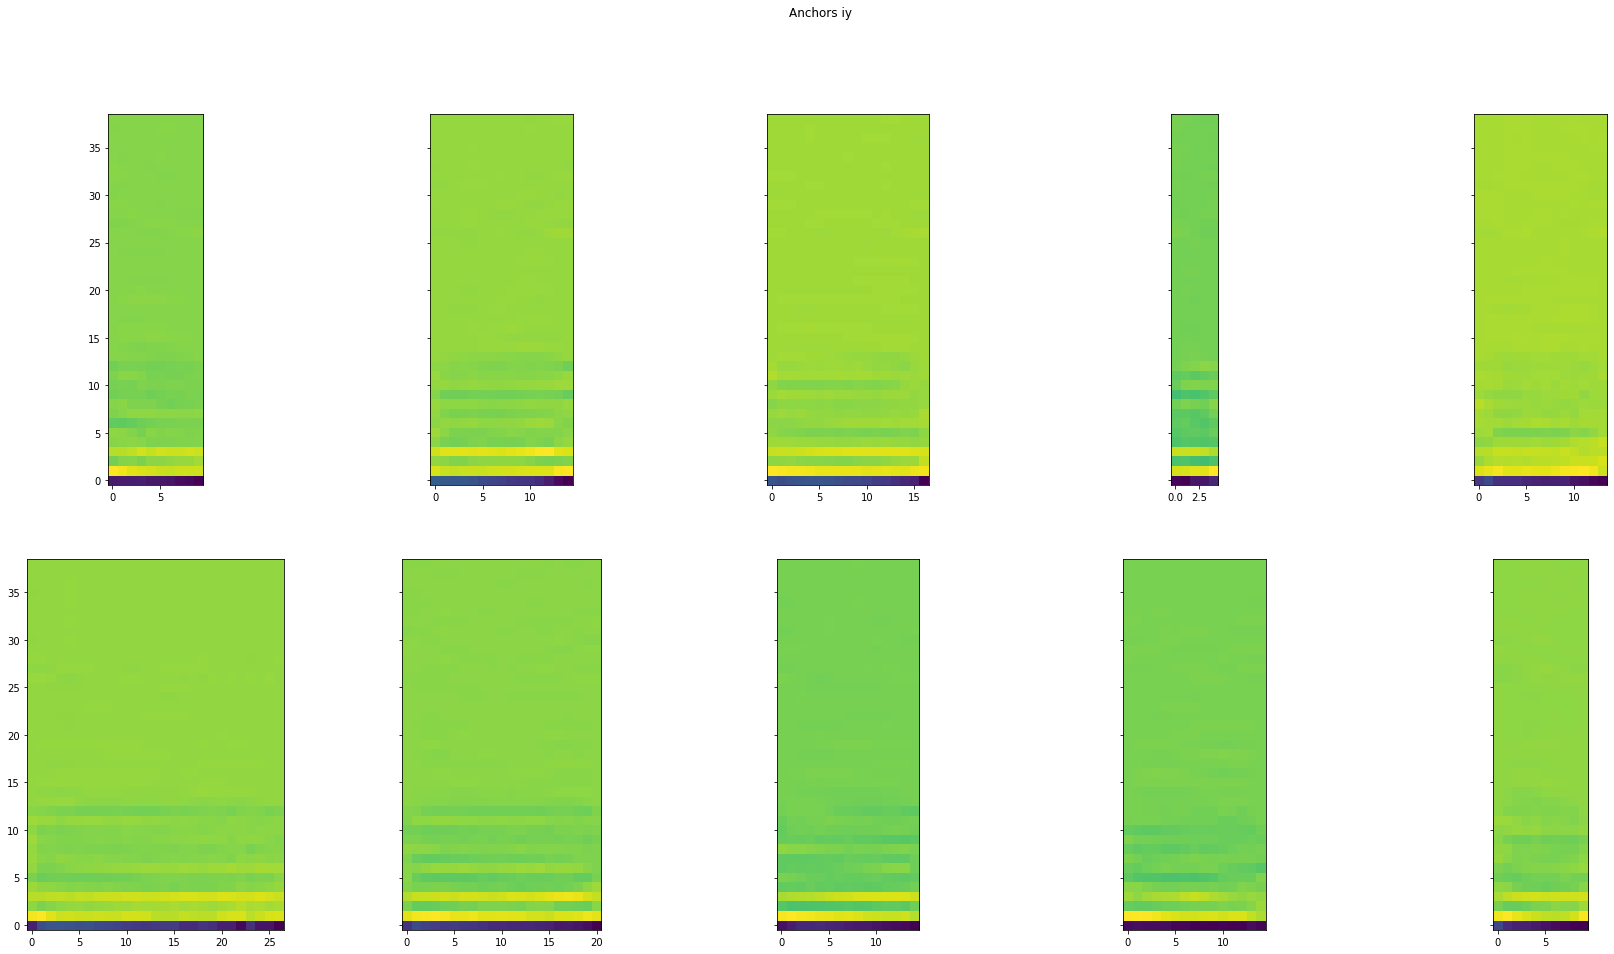

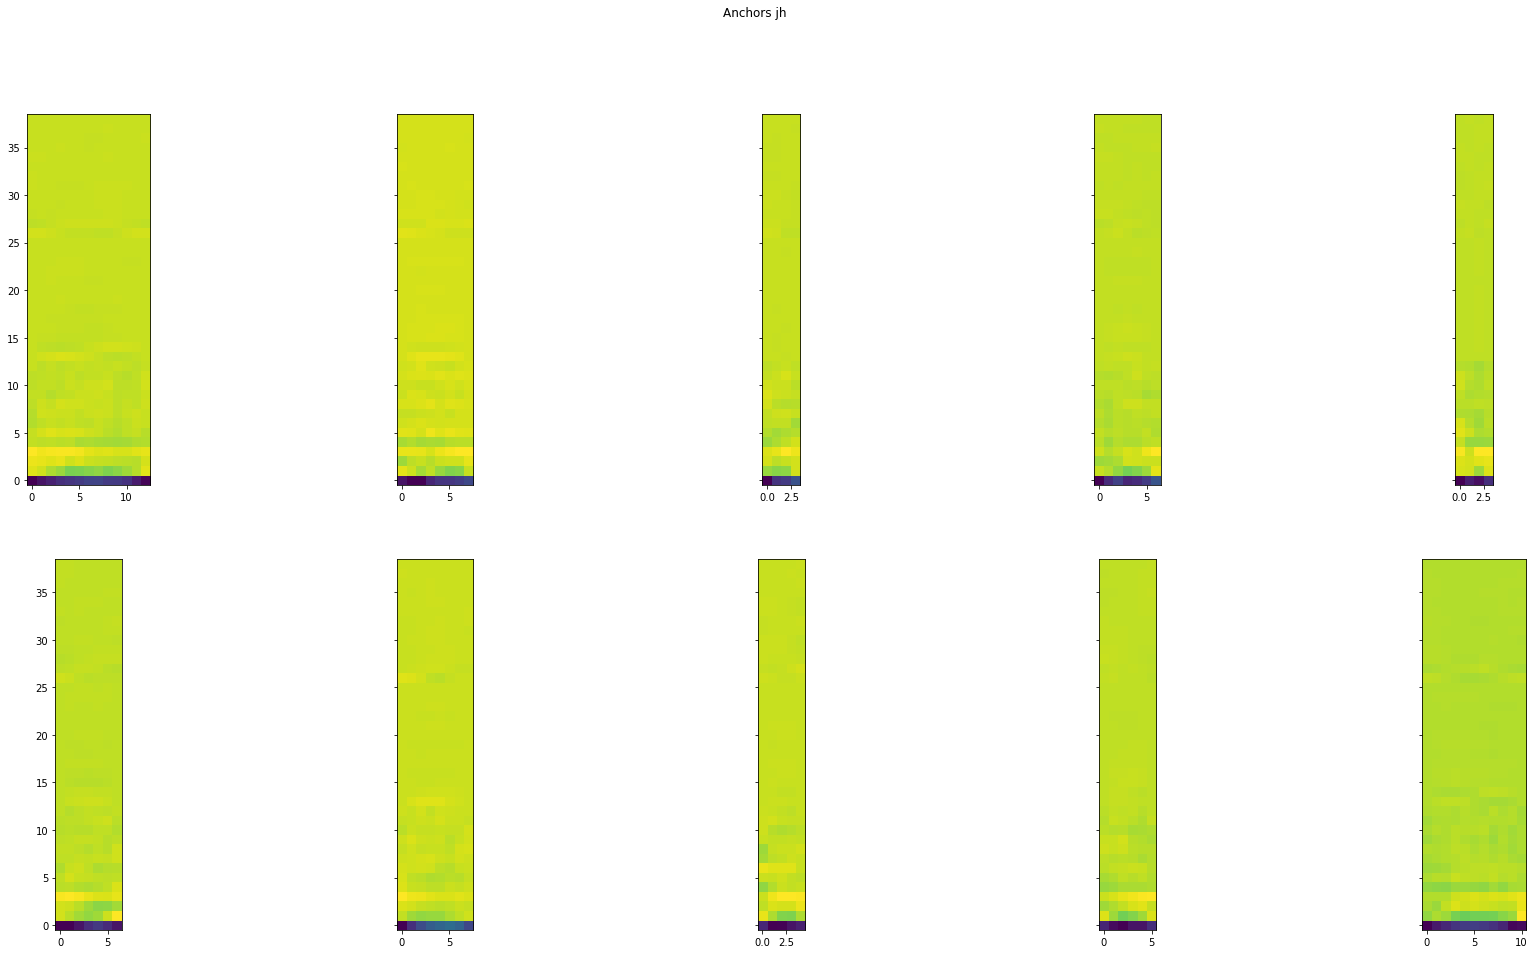

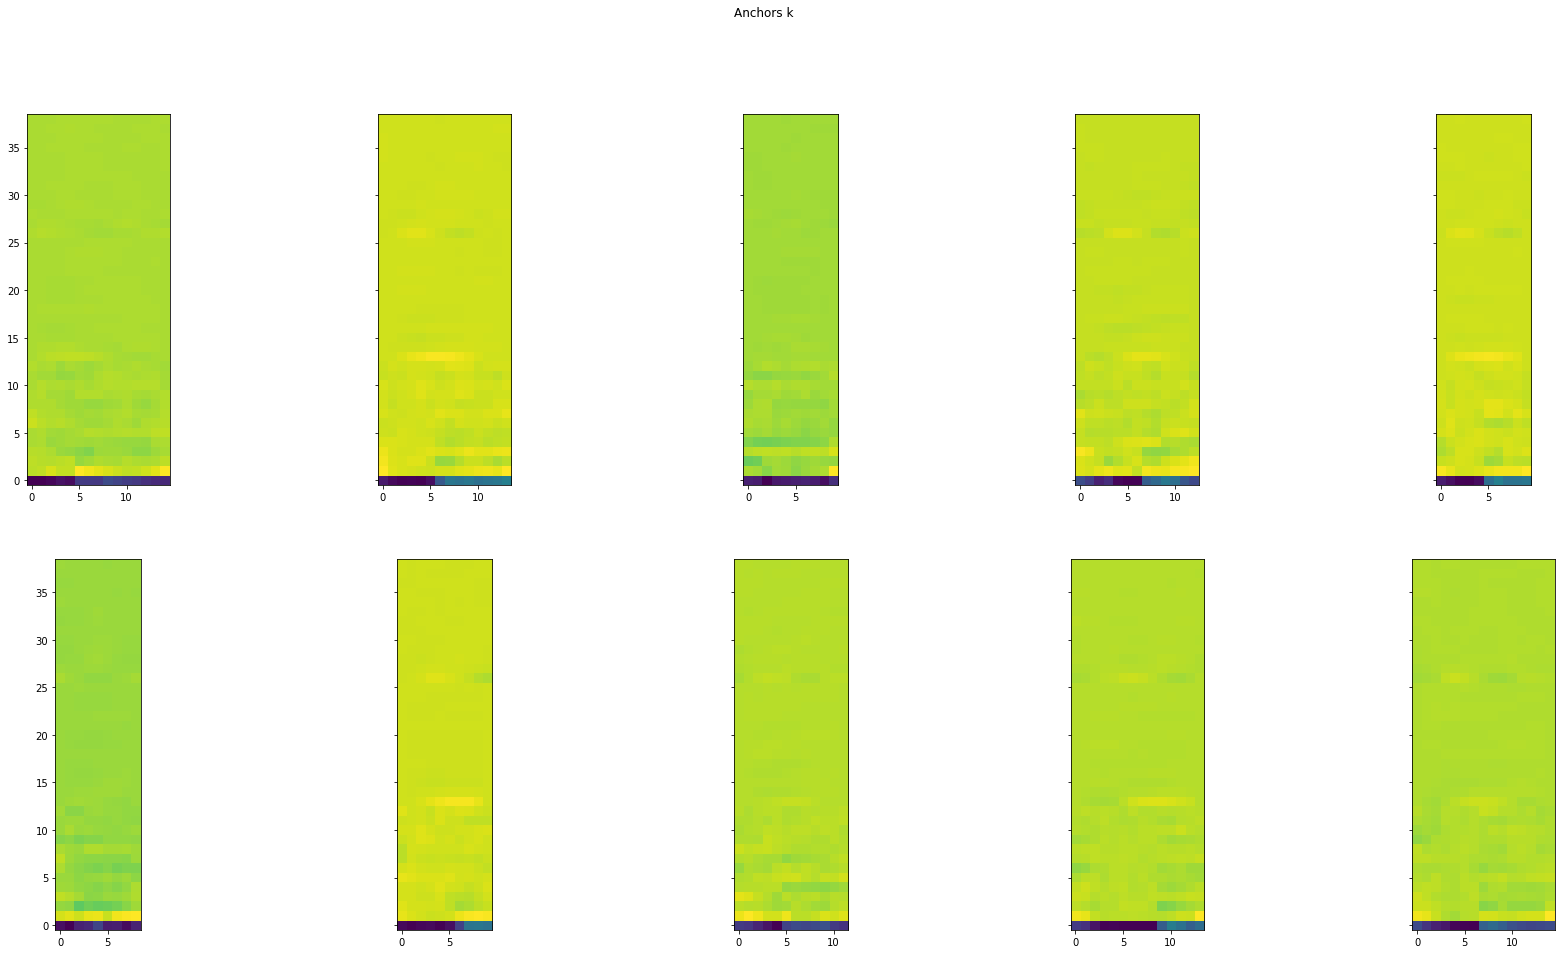

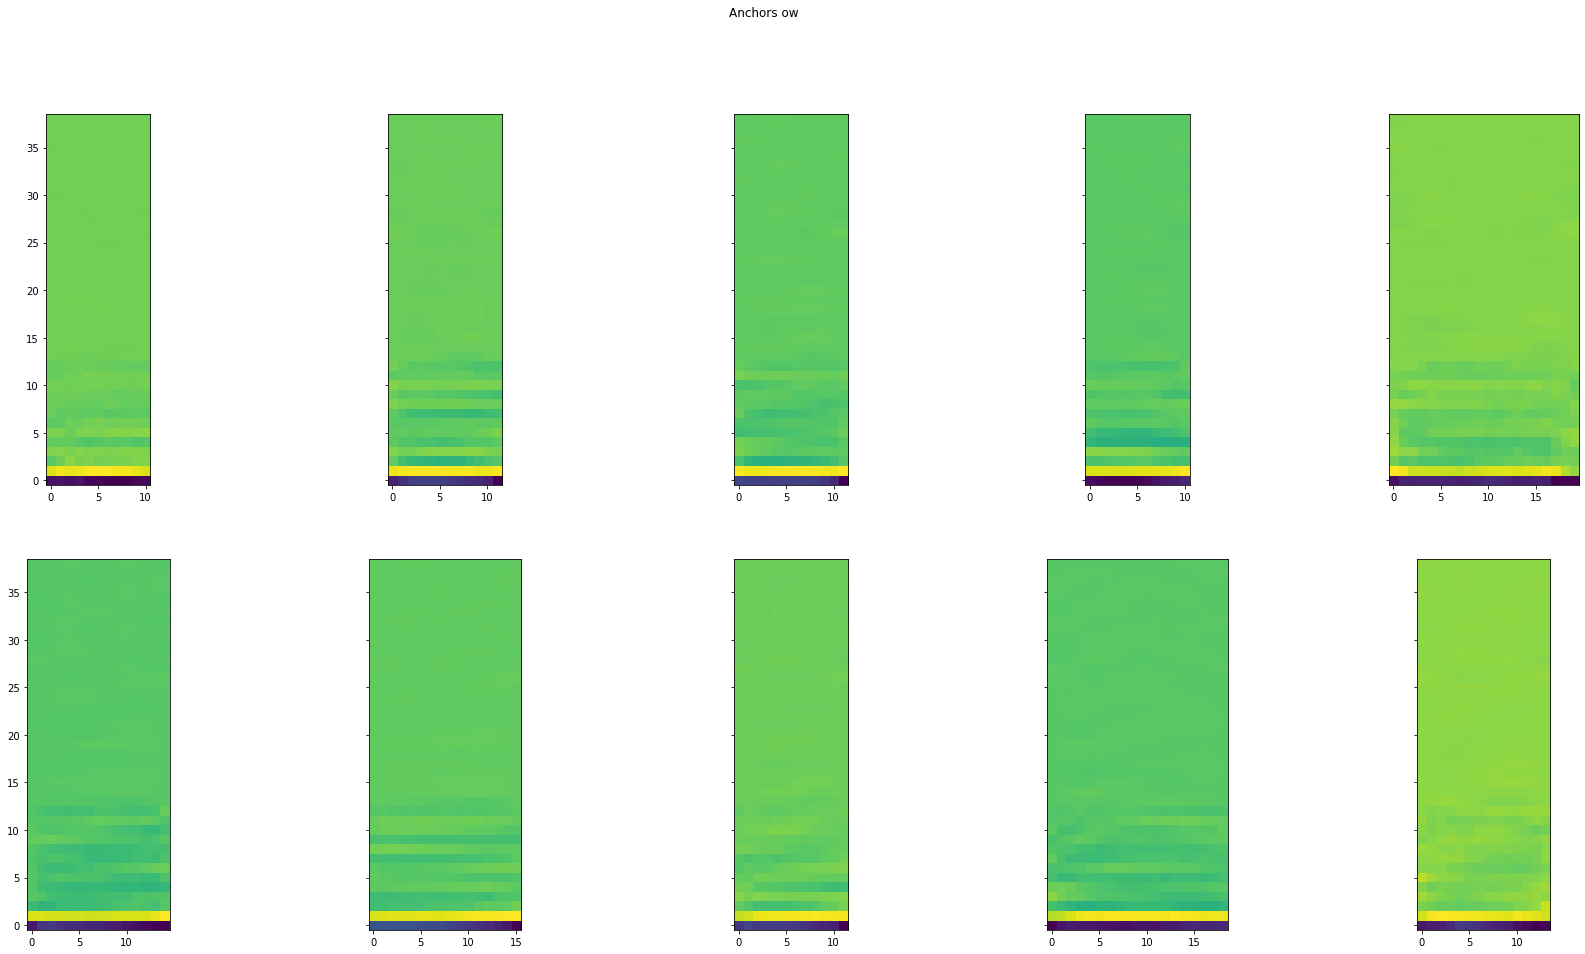

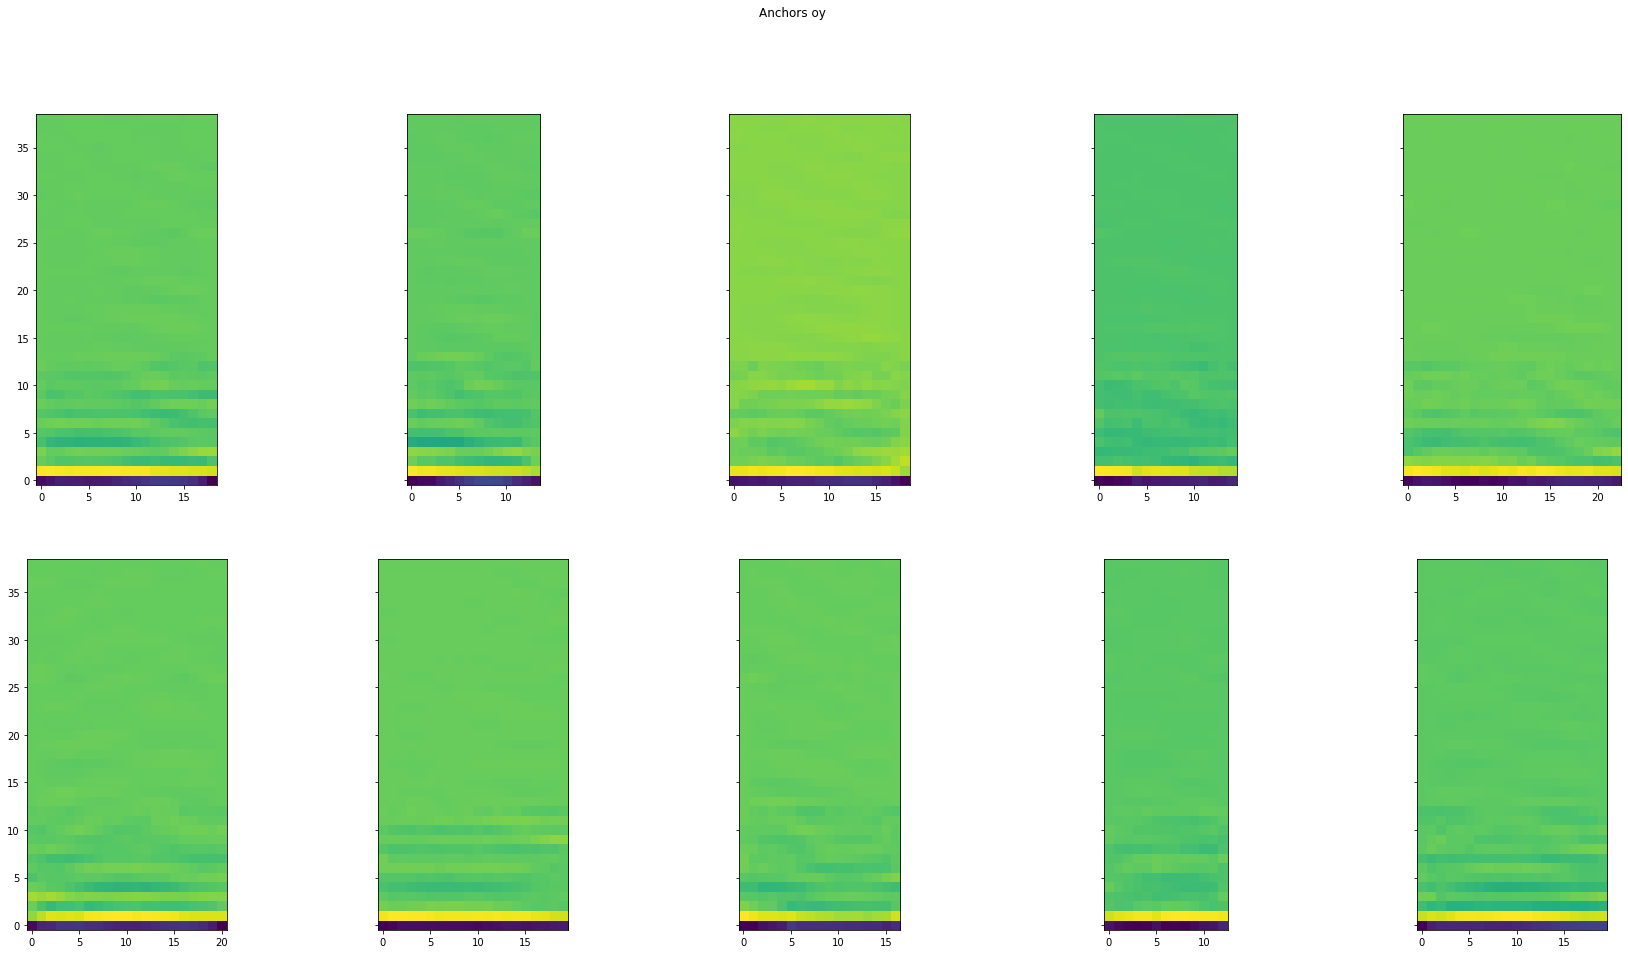

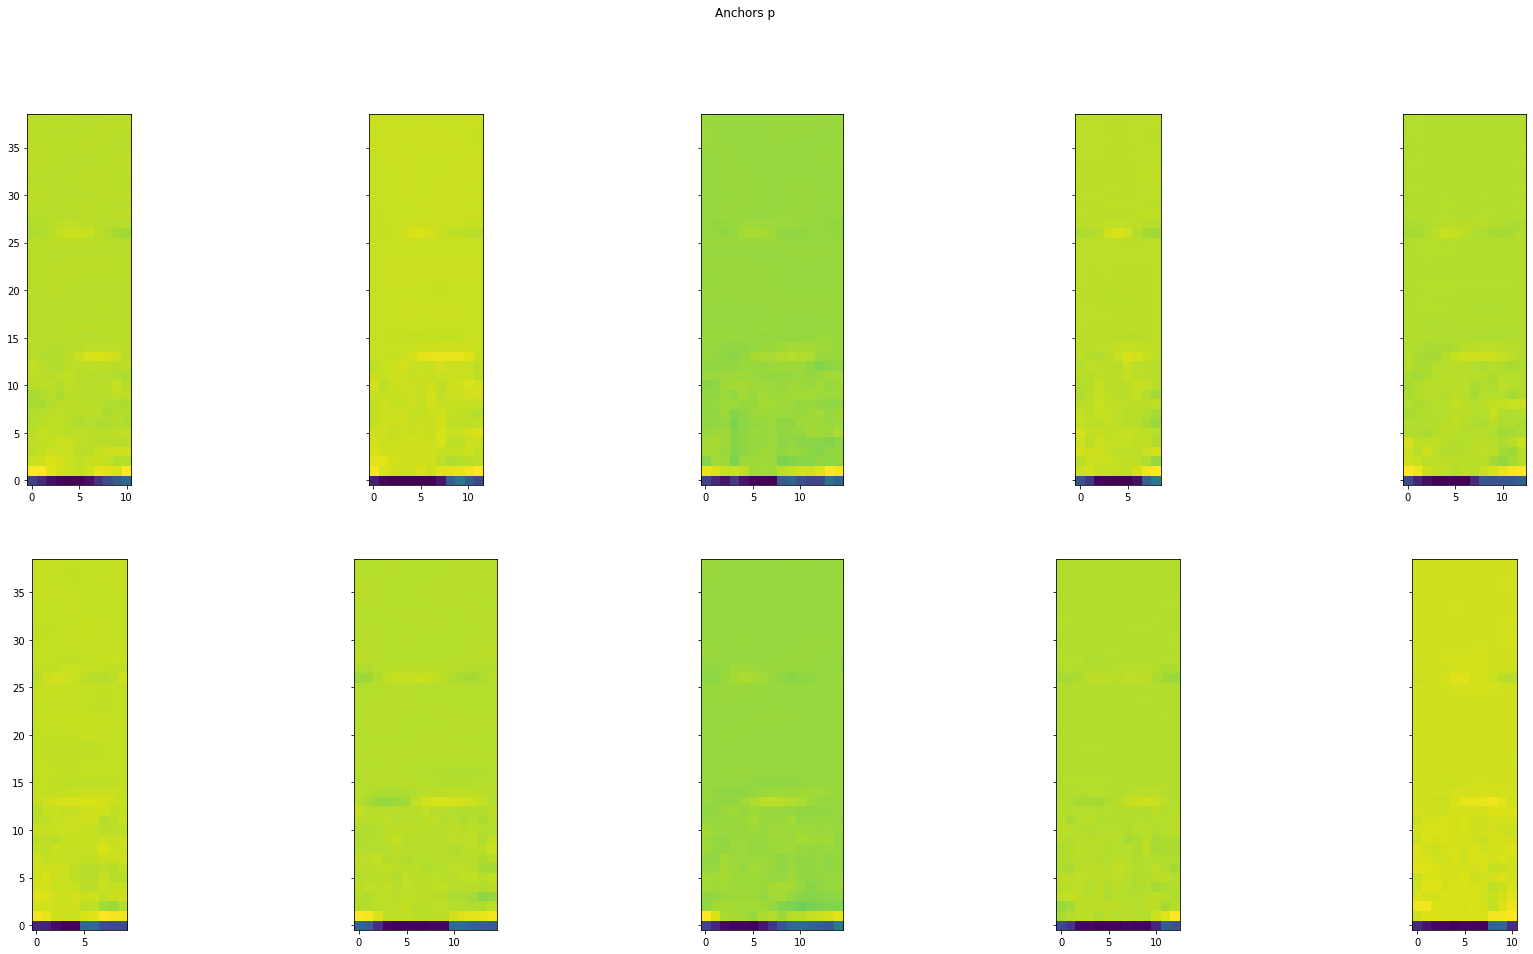

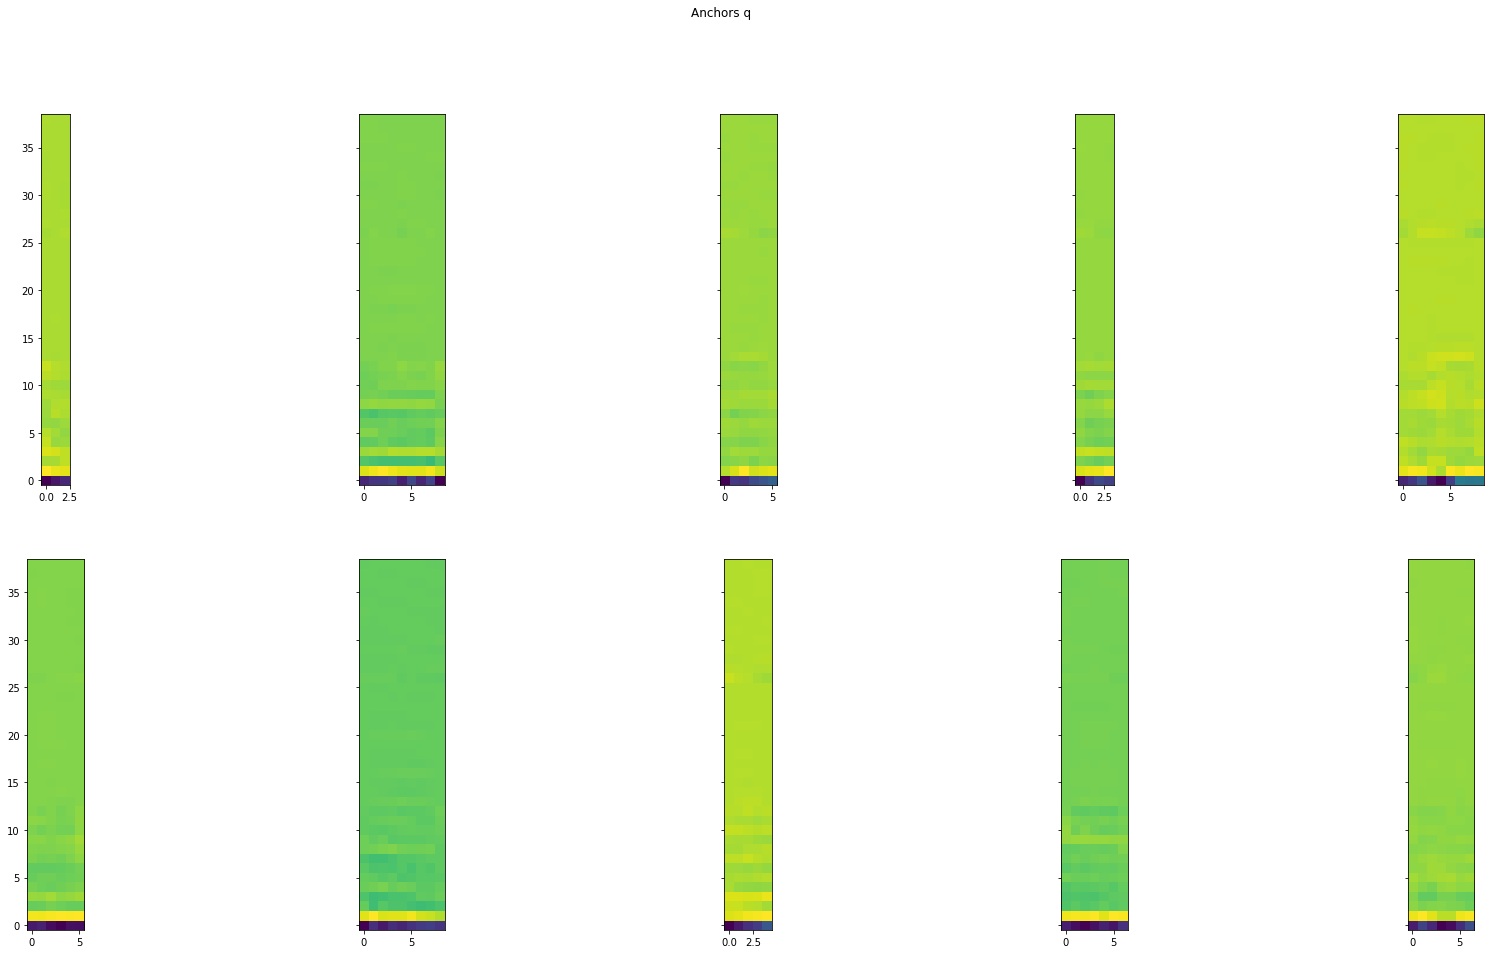

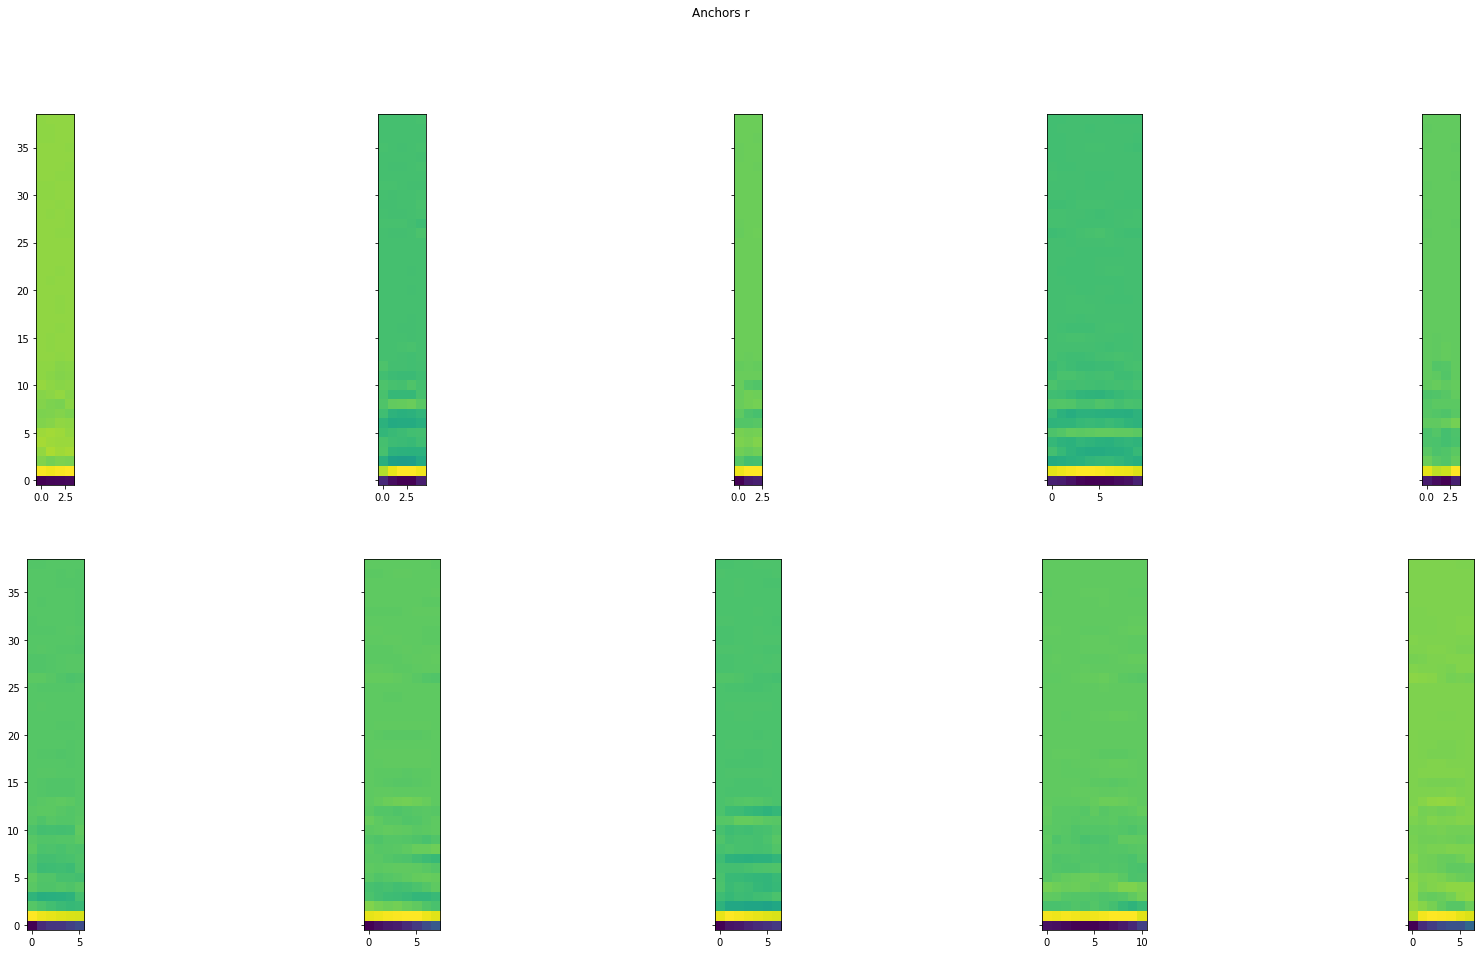

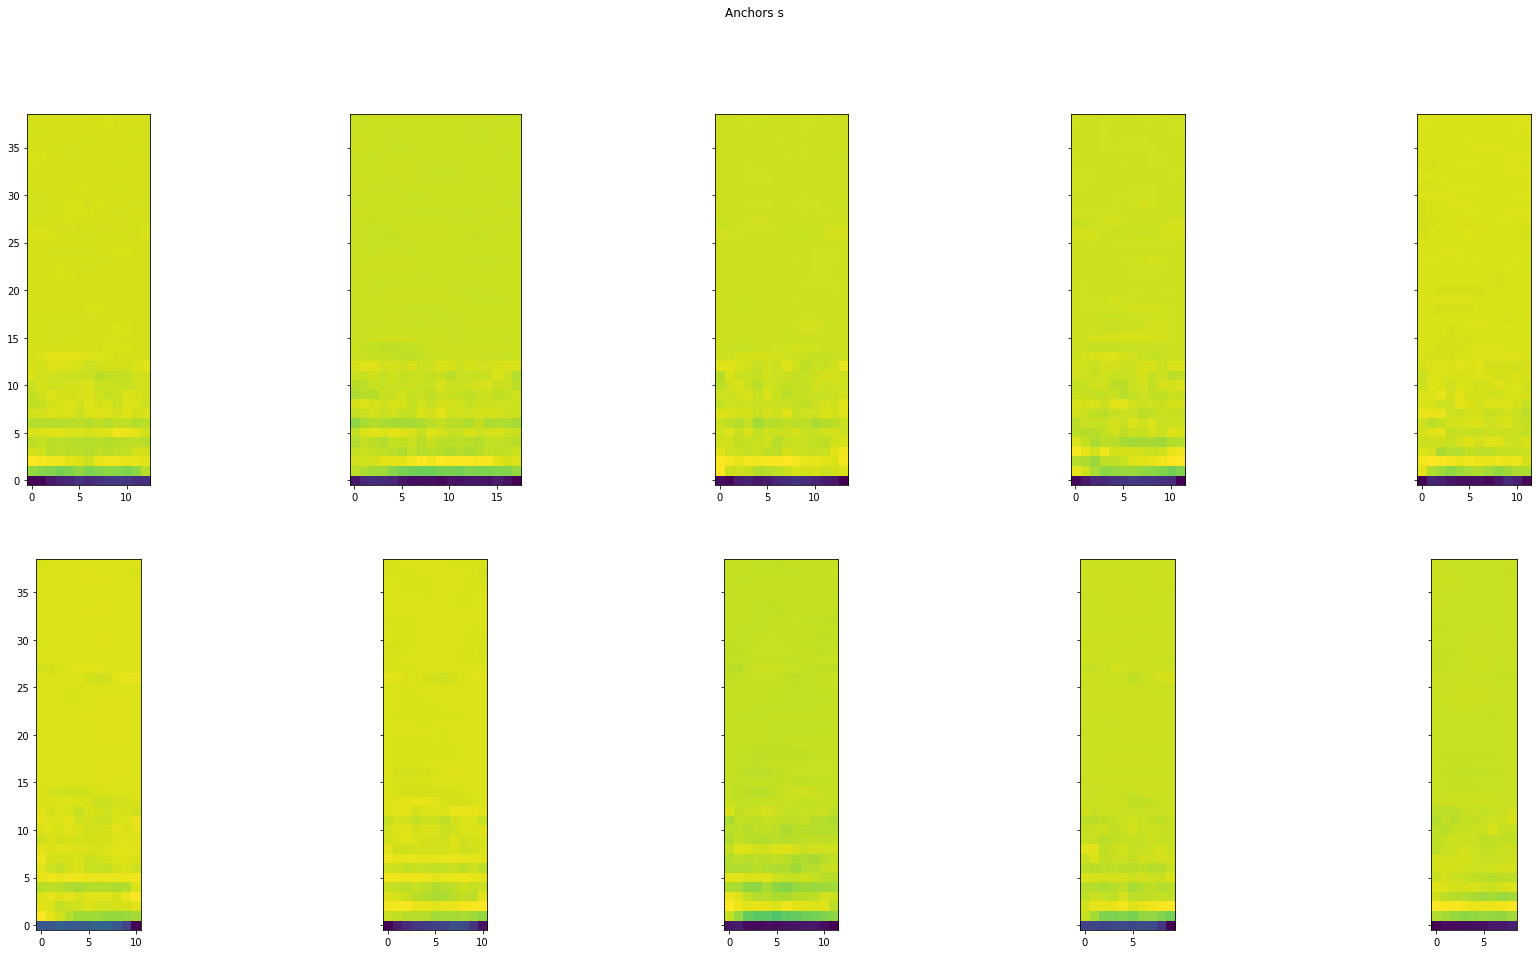

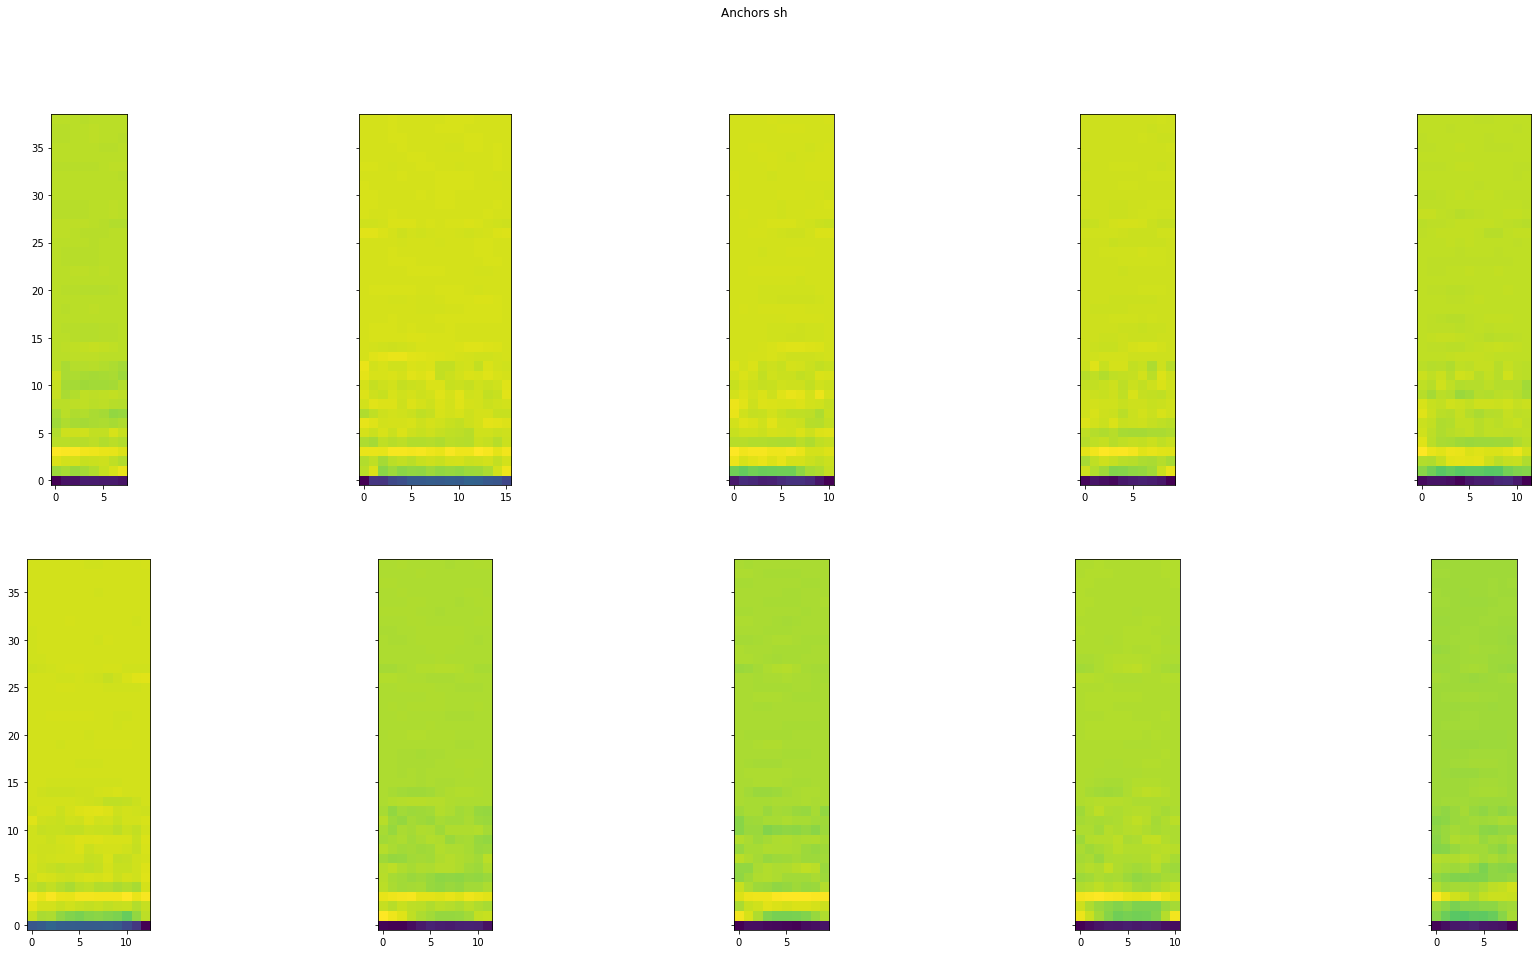

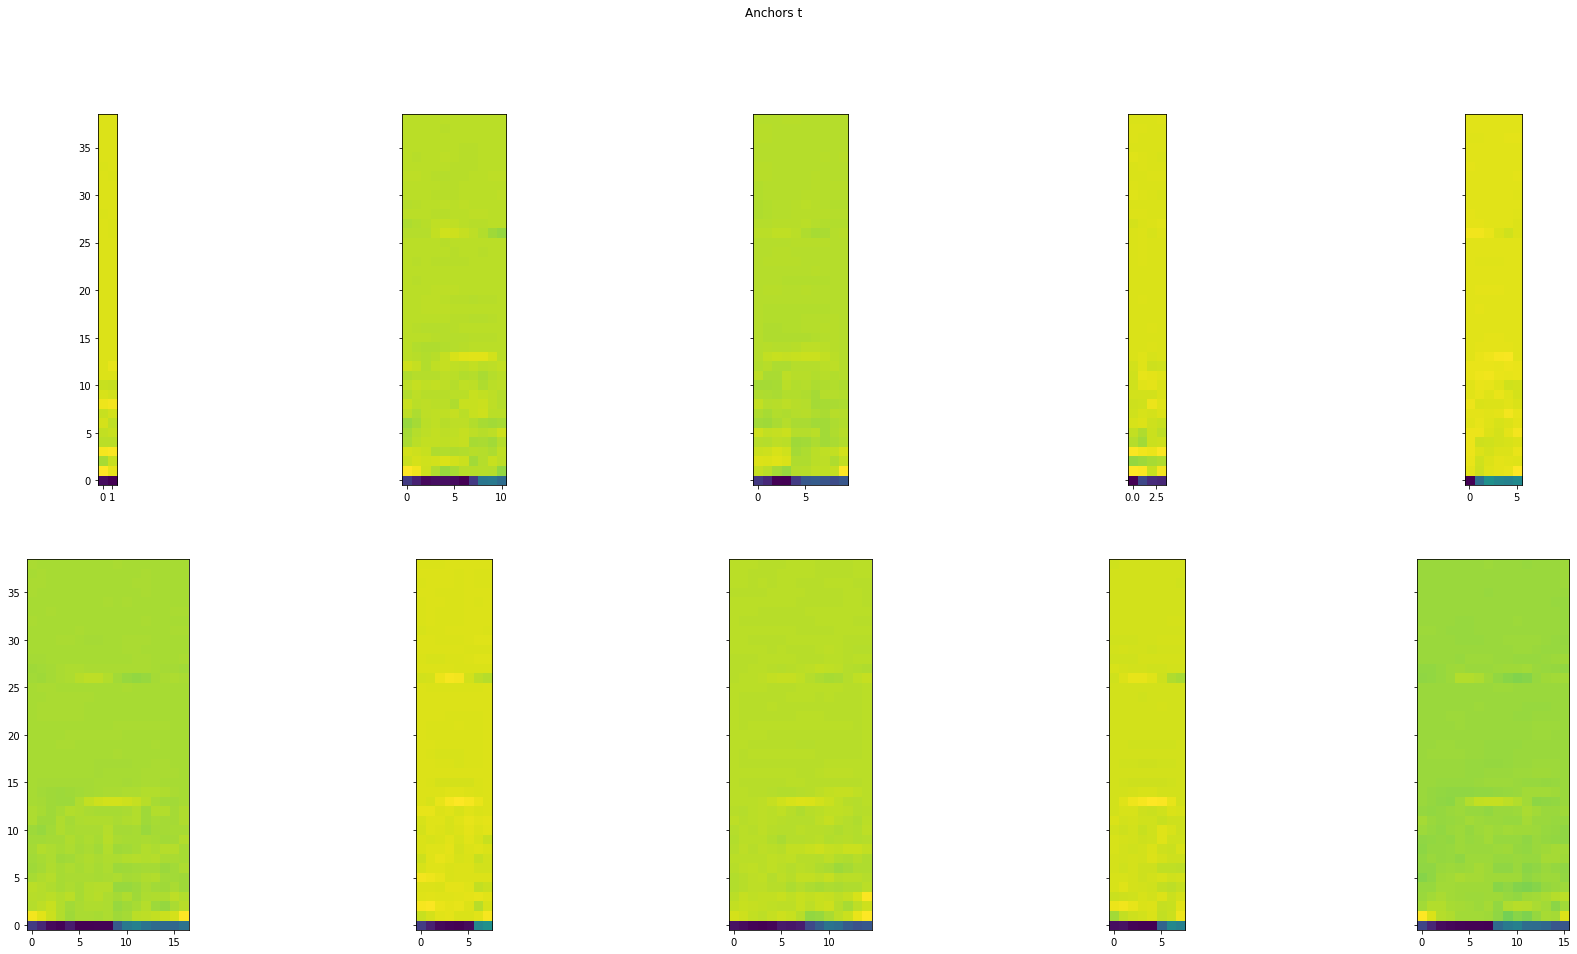

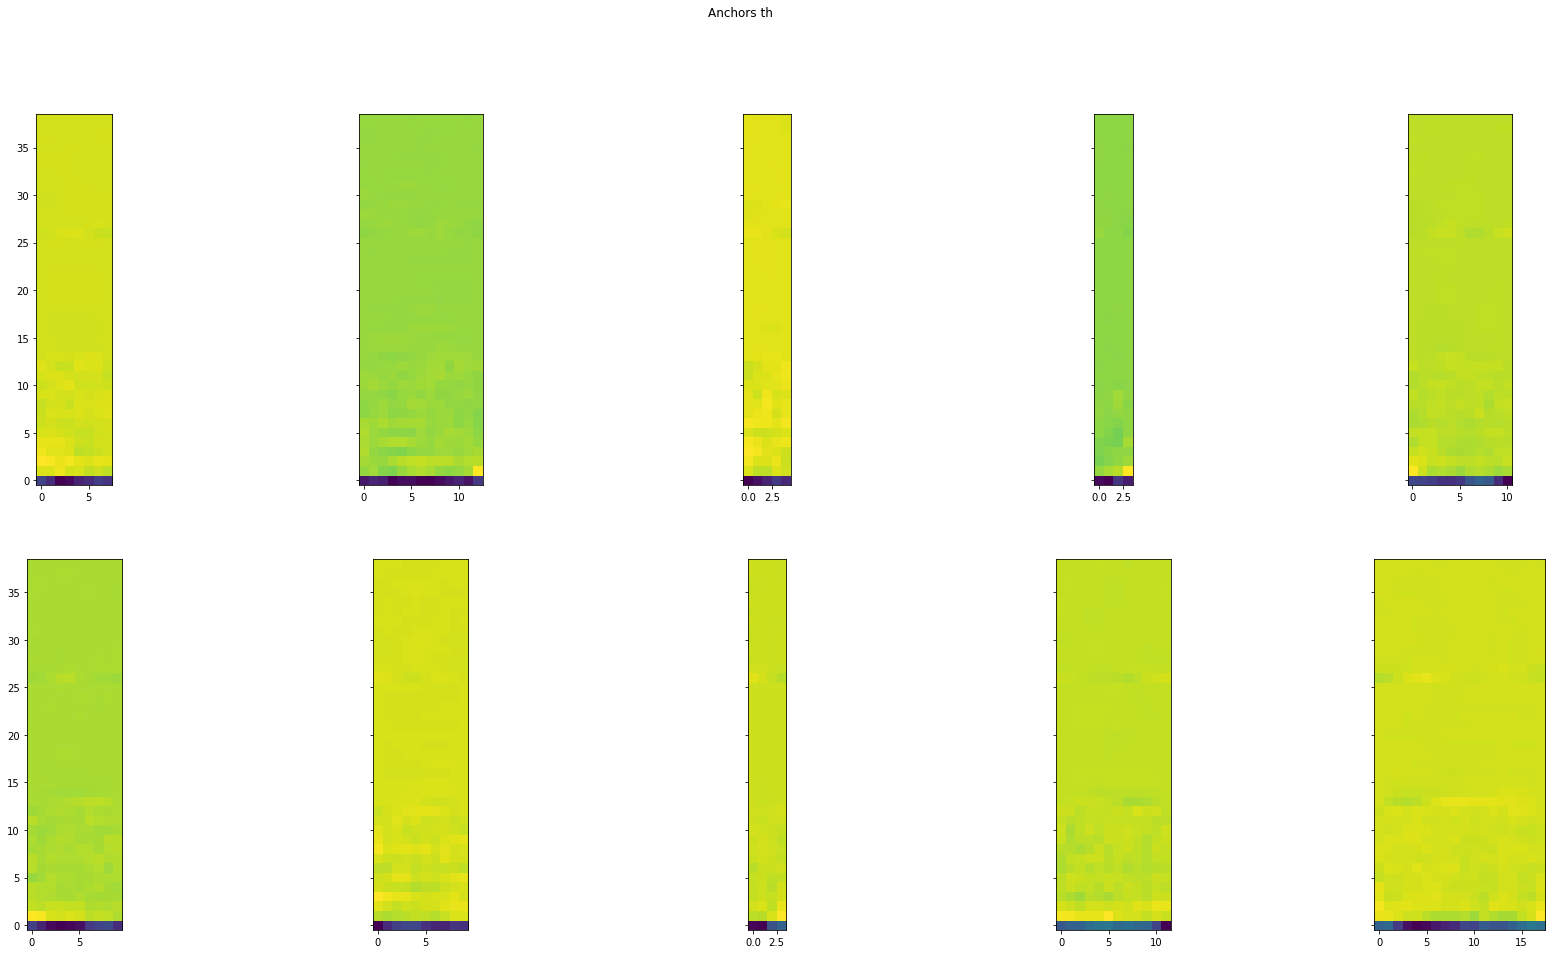

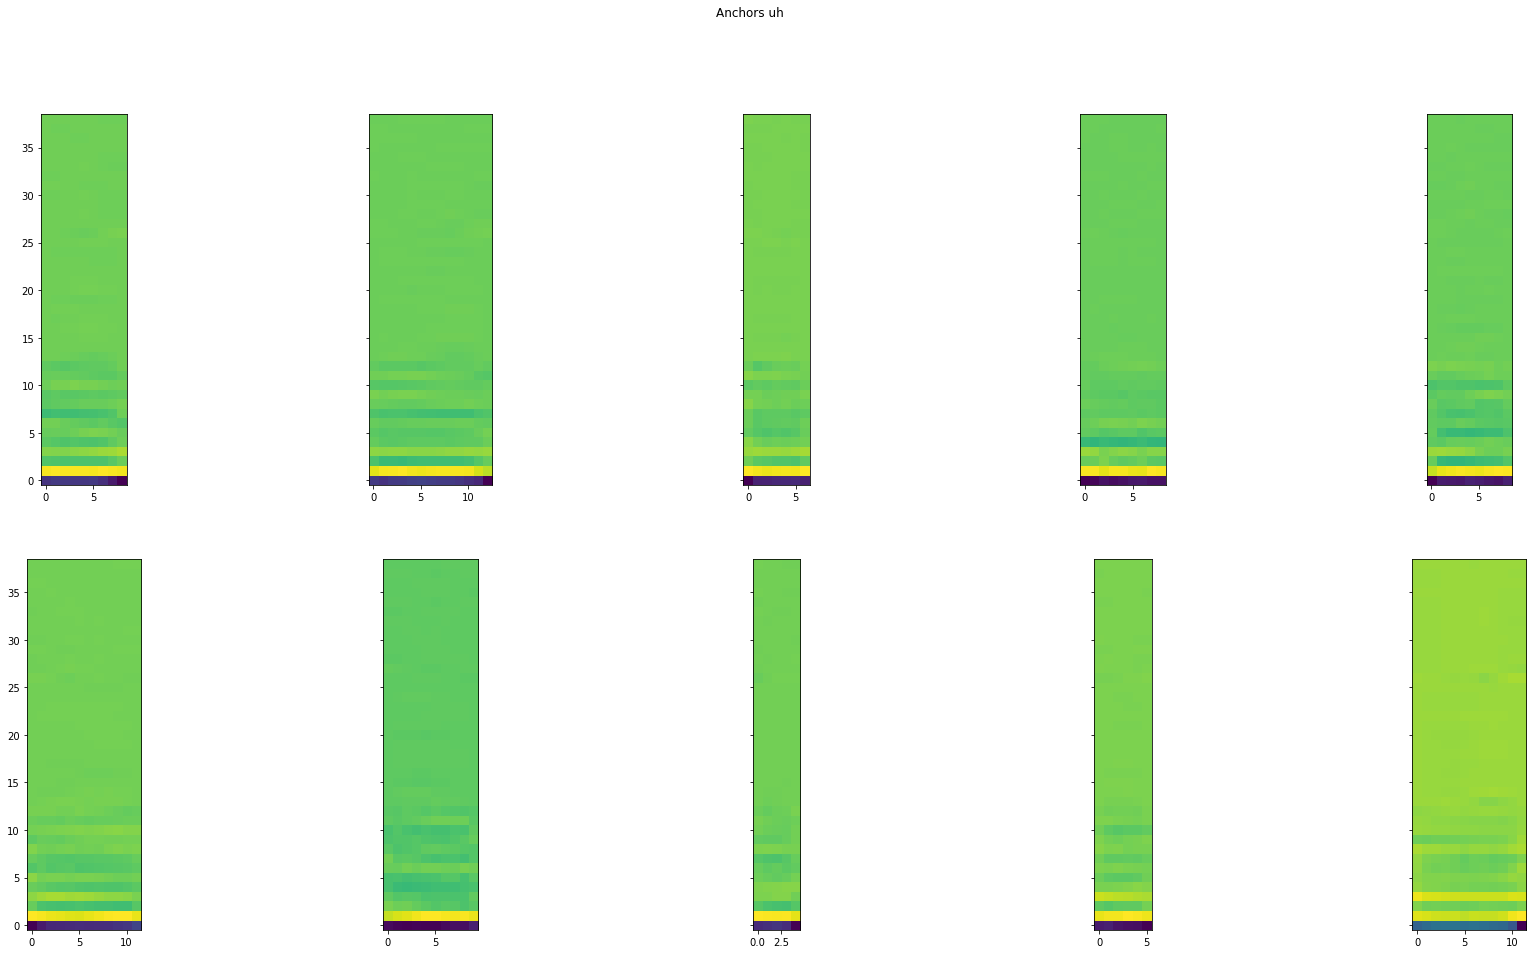

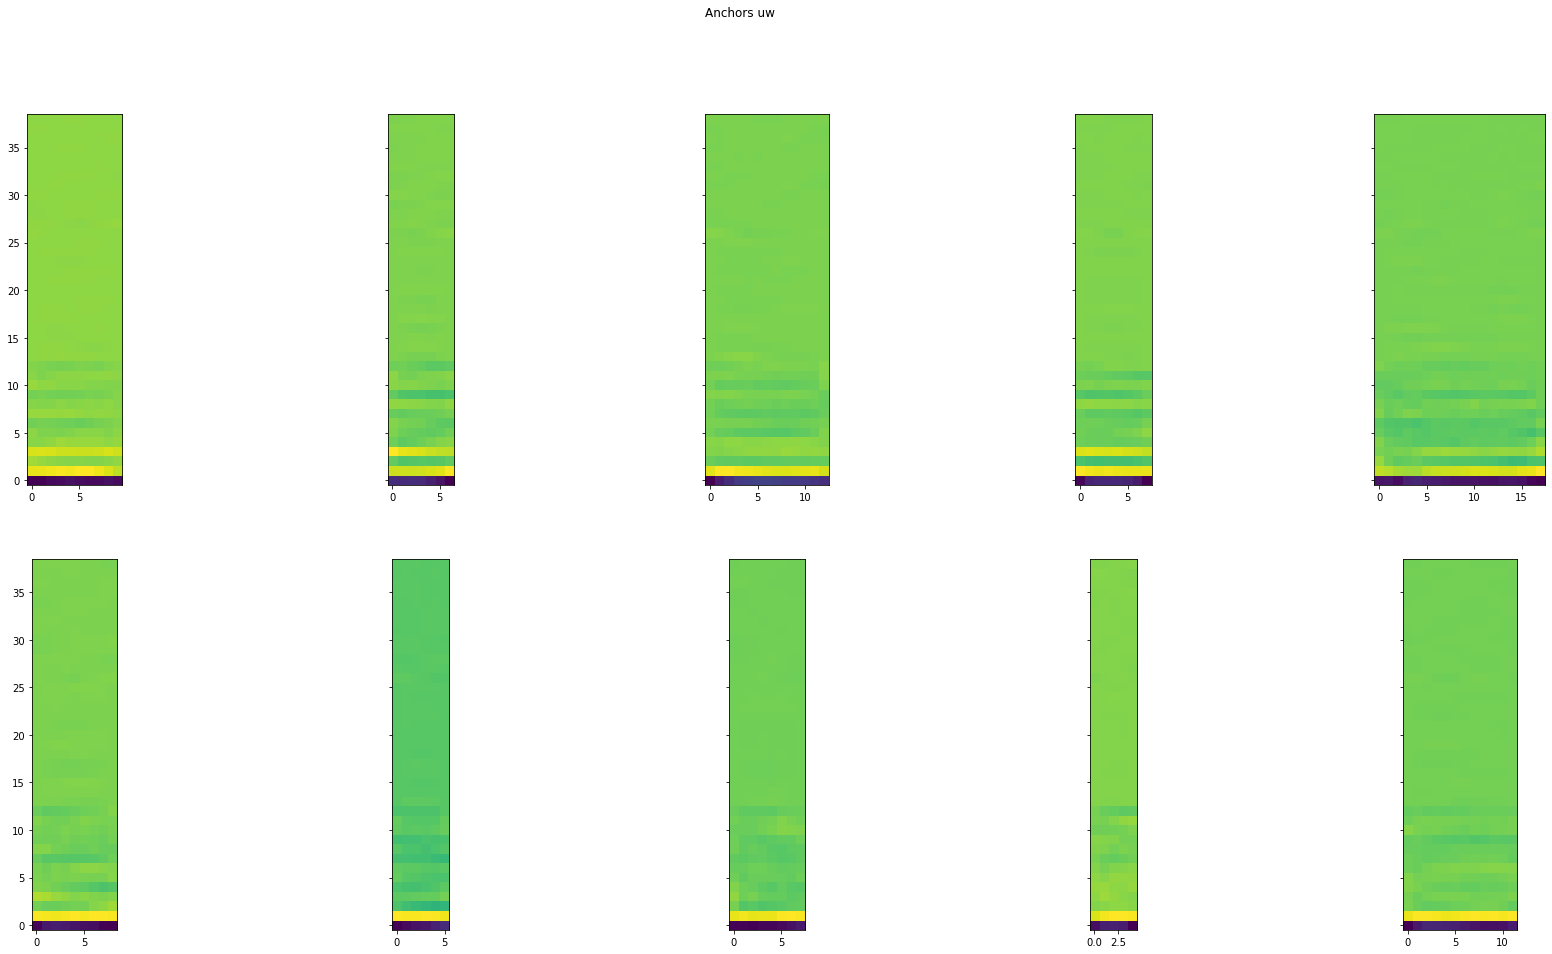

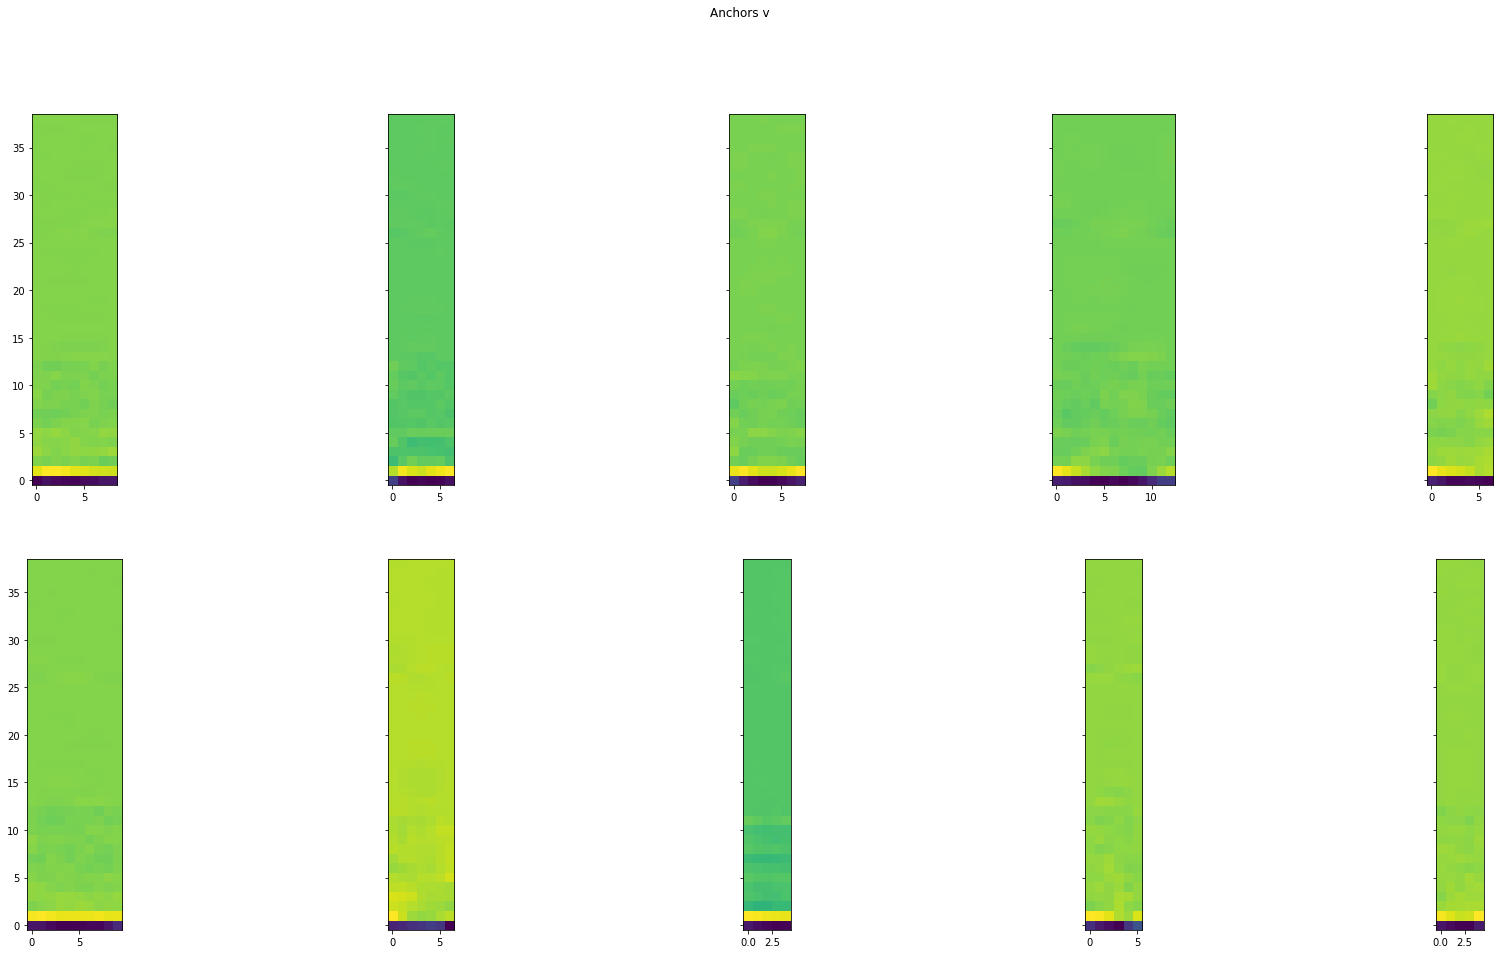

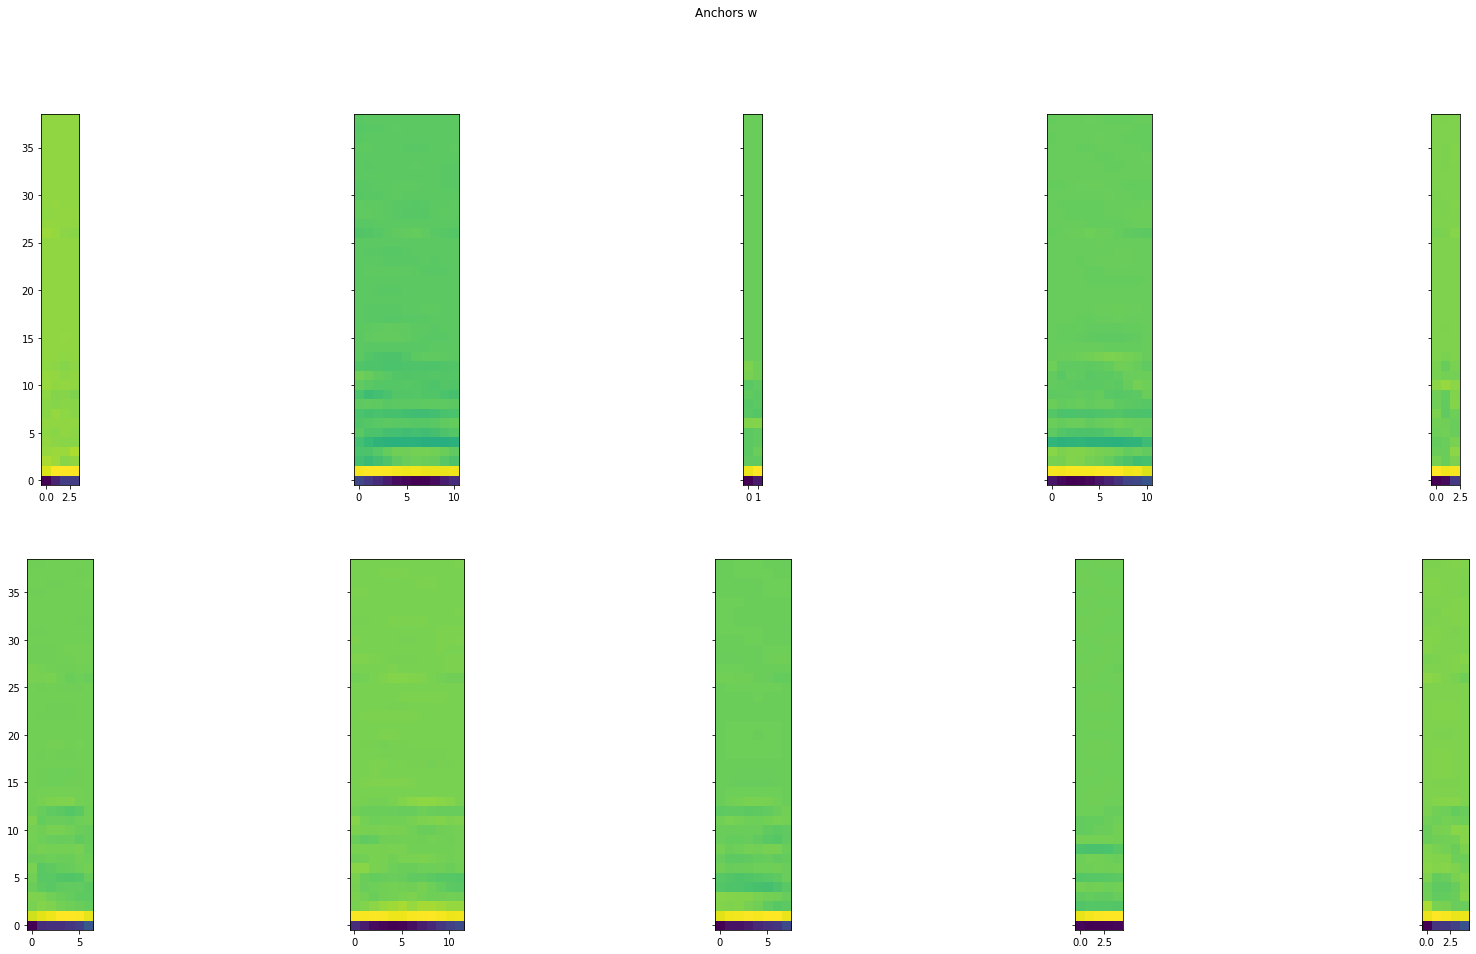

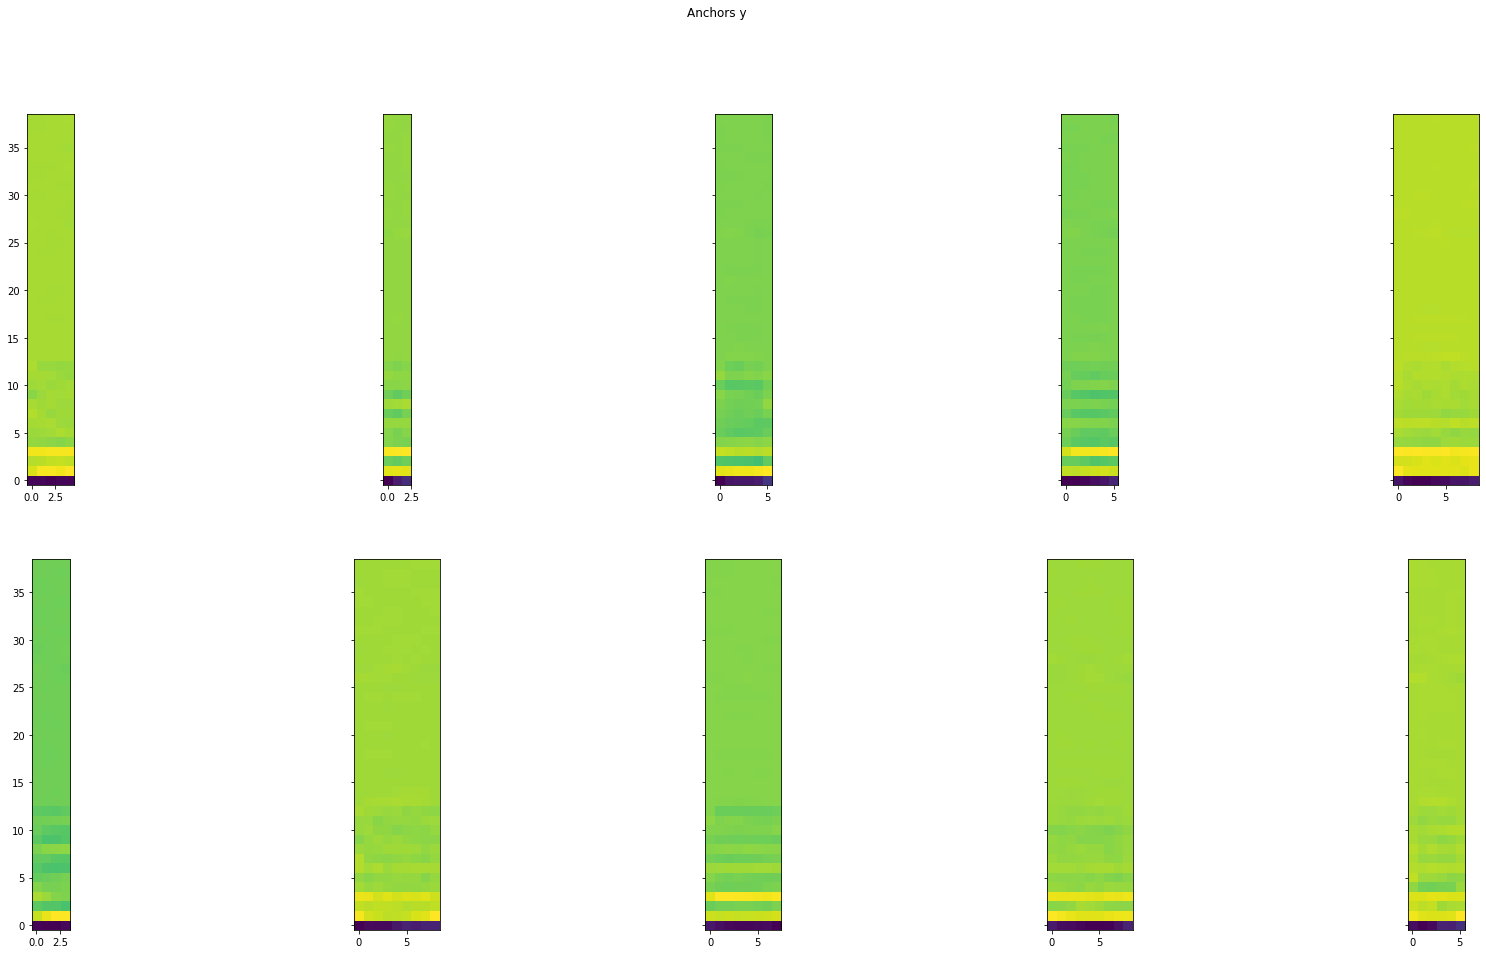

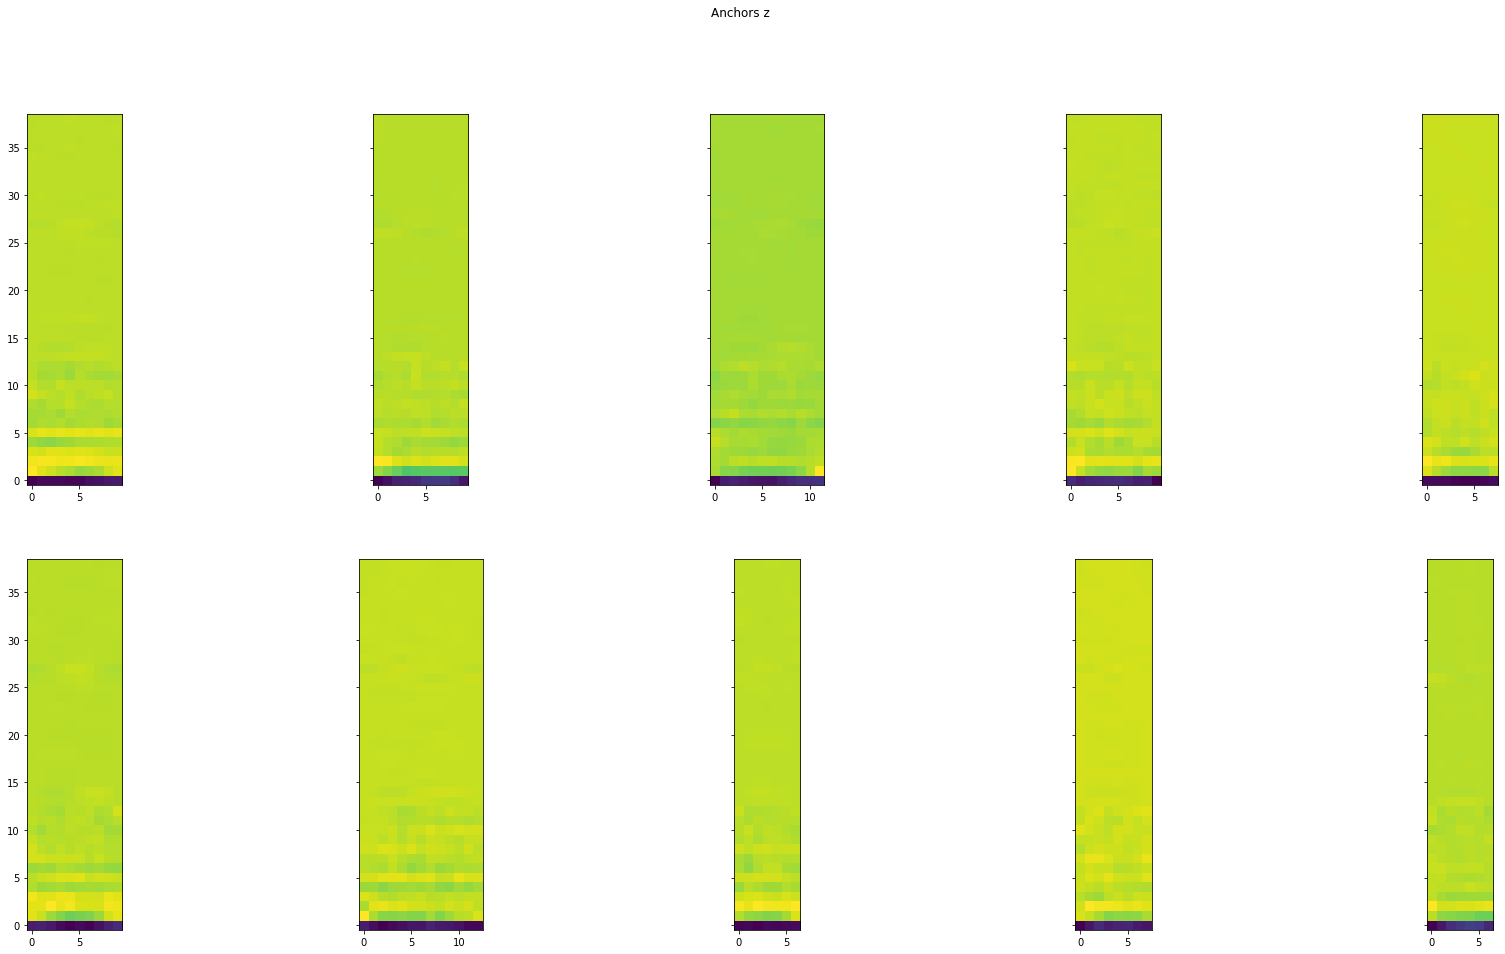

In [7]:
do_stats = False
if do_stats:
    mfcc_timit.setup("test")
    
    mfcc_timit.df_data_train["gt"] = mfcc_timit.df_data_train["gt"].map(lambda x: labels_timit[x])
    mfcc_timit.df_data_test["gt"] = mfcc_timit.df_data_test["gt"].map(lambda x: labels_timit[x])
    
    print('train stats:')
    print(f'number of examples in train: {mfcc_timit.df_data_train["gt"].count()}')
    print(f"number of examples per gt:\n{mfcc_timit.df_data_train['gt'].value_counts()}")
    print(f"number of different speakers: {mfcc_timit.df_data_train['speaker_id'].nunique()}")
    print(f"number of examples per sex:\n{mfcc_timit.df_data_train['sex'].value_counts()}")
    print(f"number of examples per region:\n{mfcc_timit.df_data_train['region'].value_counts()}")
    
    print('test stats:')
    print(f'number of examples in test: {mfcc_timit.df_data_test["gt"].count()}')
    print(f"number of examples per gt:\n{mfcc_timit.df_data_test['gt'].value_counts()}")
    print(f"number of different speakers: {mfcc_timit.df_data_test['speaker_id'].nunique()}")
    print(f"number of examples per sex:\n{mfcc_timit.df_data_test['sex'].value_counts()}")
    print(f"number of examples per region:\n{mfcc_timit.df_data_test['region'].value_counts()}")
    
    # show anchors
    import matplotlib.pyplot as plt
    
    anchors = {}
    for i in labels_timit:
        anchors[i] = []
        
    for anchor in mfcc_timit.anchors:
        anchors[labels_timit[anchor[1]]].append(anchor[0].numpy().transpose())
        
    for anchor in anchors.keys():
        fig, ax = plt.subplots(2, 5, figsize=(30,15), sharey=True)
        fig.suptitle(f'Anchors {anchor}')
        i = 0
        for a in anchors[anchor]:
            ax[i//5, i%5].imshow(a, origin='lower')
            i += 1
        
        plt.show()

## First 1000 epochs

In [8]:
# init model
model = lit_mfcc_model(13*3, mfcc_timit.anchors, mfcc_timit.timit_gt.phon_size, shots, labels_timit) # features = MFCC + delta+ deltas deltas
model.to('cuda')

# trainer definition
trainer = pl.Trainer(
     callbacks=[
#        EarlyStopping(monitor='val_accuracy_argmin', patience=200, mode="max"),
        LearningRateMonitor(logging_interval='epoch')
    ],
    checkpoint_callback=ModelCheckpoint(save_top_k=5, monitor="val_accuracy_argmin", mode="max"),
    progress_bar_refresh_rate=None,
    gpus=1, auto_select_gpus=True,
    check_val_every_n_epoch=10,
    precision=16,
    max_epochs=1000
)

trainer.fit(model, mfcc_timit)

/home/vroger/.miniconda3/envs/audio_loader/lib/python3.8/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type              | Params
----------------------------------------------------
0 | layer_1_grus  | GRU               | 5.2 M 
1 | bn_fwd        | BatchNorm1d       | 512   
2 | bn_bwd        | BatchNorm1d       | 512   
3 | layer_2_dense | Linear            | 65.7 K
4 | alpha         | Linear            | 16.4 K
5 | loss          | BCEWithLogitsLoss | 0     
----------------------------------------------------
5.3 M     Trainable params
0         Non-trainable params
5.3 M     Total params
21.081    Total estimated model params size (MB)


valid 4
Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/home/vroger/.miniconda3/envs/audio_loader/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


train 12                                                              
Epoch 0:   0%|          | 0/12 [00:00<?, ?it/s] 

/home/vroger/.miniconda3/envs/audio_loader/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 9:  75%|███████▌  | 12/16 [00:01<00:00,  9.75it/s, loss=0.59, v_num=424] 
Validating: 0it [00:00, ?it/s]
Epoch 19:  75%|███████▌  | 12/16 [00:01<00:00,  9.92it/s, loss=0.652, v_num=424]
Validating: 0it [00:00, ?it/s]
Epoch 29:  75%|███████▌  | 12/16 [00:01<00:00,  9.58it/s, loss=0.548, v_num=424]
Validating: 0it [00:00, ?it/s]
Epoch 39:  75%|███████▌  | 12/16 [00:01<00:00,  9.68it/s, loss=0.518, v_num=424]
Validating: 0it [00:00, ?it/s]
Epoch 49:  75%|███████▌  | 12/16 [00:01<00:00,  9.62it/s, loss=0.485, v_num=424]
Validating: 0it [00:00, ?it/s]
Epoch 59:  75%|███████▌  | 12/16 [00:01<00:00,  9.93it/s, loss=0.508, v_num=424]
Validating: 0it [00:00, ?it/s]
Epoch 69:  75%|███████▌  | 12/16 [00:01<00:00,  9.65it/s, loss=0.496, v_num=424]
Validating: 0it [00:00, ?it/s]
Epoch 79:  75%|███████▌  | 12/16 [00:01<00:00,  9.67it/s, loss=0.575, v_num=424]
Validating: 0it [00:00, ?it/s]
Epoch 89:  75%|███████▌  | 12/16 [00:01<00:00,  9.19it/s, loss=0.527, v_num=424]
Validating: 0it [00:00, 

1

## Last epochs

In [9]:
trainer = pl.Trainer(
    callbacks=[
#        EarlyStopping(monitor='val_accuracy_argmin', patience=200, mode="max"),
        LearningRateMonitor(logging_interval='epoch')
    ],
    checkpoint_callback=ModelCheckpoint(save_top_k=5, monitor="val_accuracy_argmin", mode="max"),
    progress_bar_refresh_rate=None,
    gpus=1, auto_select_gpus=True,
    check_val_every_n_epoch=5,
    precision=16,
    max_epochs=2000
)
trainer.fit(model, mfcc_timit)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type              | Params
----------------------------------------------------
0 | layer_1_grus  | GRU               | 5.2 M 
1 | bn_fwd        | BatchNorm1d       | 512   
2 | bn_bwd        | BatchNorm1d       | 512   
3 | layer_2_dense | Linear            | 65.7 K
4 | alpha         | Linear            | 16.4 K
5 | loss          | BCEWithLogitsLoss | 0     
----------------------------------------------------
5.3 M     Trainable params
0         Non-trainable params
5.3 M     Total params
21.081    Total estimated model params size (MB)


valid 4
train 12                                                              
Epoch 4:  75%|███████▌  | 12/16 [00:01<00:00, 10.07it/s, loss=0.194, v_num=427]
Validating: 0it [00:00, ?it/s]
Epoch 9:  75%|███████▌  | 12/16 [00:01<00:00,  9.99it/s, loss=0.245, v_num=427]
Validating: 0it [00:00, ?it/s]
Epoch 14:  75%|███████▌  | 12/16 [00:01<00:00,  9.78it/s, loss=0.295, v_num=427]
Validating: 0it [00:00, ?it/s]
Epoch 19:  75%|███████▌  | 12/16 [00:01<00:00,  9.77it/s, loss=0.309, v_num=427]
Validating: 0it [00:00, ?it/s]
Epoch 24:  75%|███████▌  | 12/16 [00:01<00:00, 10.17it/s, loss=0.27, v_num=427] 
Validating: 0it [00:00, ?it/s]
Epoch 29:  75%|███████▌  | 12/16 [00:01<00:00, 10.09it/s, loss=0.221, v_num=427]
Validating: 0it [00:00, ?it/s]
Epoch 34:  75%|███████▌  | 12/16 [00:01<00:00,  9.93it/s, loss=0.232, v_num=427]
Validating: 0it [00:00, ?it/s]
Epoch 39:  75%|███████▌  | 12/16 [00:01<00:00,  9.98it/s, loss=0.158, v_num=427]
Validating: 0it [00:00, ?it/s]
Epoch 44:  75%|███████▌  | 

1

## Test

In [10]:
if not do_stats:
    mfcc_timit.setup("test")

trainer.test(test_dataloaders=mfcc_timit.test_dataloader(), ckpt_path='best')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


test 218
Testing: 0it [00:00, ?it/s]

/home/vroger/.miniconda3/envs/audio_loader/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Testing: 100%|██████████| 218/218 [24:06<00:00,  6.64s/it]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy_argmin': 0.2283891886472702,
 'test_accuracy_votes_best_10': 0.22756266593933105,
 'test_loss': 0.4074418544769287}
--------------------------------------------------------------------------------


[{'test_loss': 0.4074418544769287,
  'test_accuracy_argmin': 0.2283891886472702,
  'test_accuracy_votes_best_10': 0.22756266593933105}]